In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import datetime
import random
import time
import csv
import os

In [4]:
# sprawdzenie dostępnych urządzeń
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
class Colors:
    GREEN = "green"
    RED = "red"
    BLACK = "black"

def get_color_from_number(number: int) -> str:
    if number == 0:
        return Colors.GREEN
    if 0 < number <= 7:
        return Colors.RED
    if 8 <= number <= 14:
        return Colors.BLACK
    else:
        raise Exception("Number not in accepted range")

def get_color_number_from_color(color: str) -> int:
    if color == Colors.GREEN:
        return 0
    if color == Colors.RED:
        return 1
    if color == Colors.BLACK:
        return 2
    else:
        raise Exception(f"Color '{color}' not handled")

def split_list(lst, chunk_size) -> tuple[list[int], list[int]]:
    data = []
    labels = []
    for i in range(len(lst) - chunk_size):
        data.append(lst[i:i+chunk_size])
        labels.append(lst[i+chunk_size])
    return data, labels

def read_file(file_path: str) -> list[list[str]]:
    with open(file_path, newline='') as file:
        colors = []
        for line in file.readlines():
            numbers = line.strip().split(",")
            try:
                parsed_numbers = list(map(lambda x: int(x), numbers))
                colors.append(list(map(get_color_from_number, parsed_numbers)))
            except Exception as e:
                # parsing numbers failed - that means numbers list contains color strings
                colors.append(numbers)
        return colors

def count_color_sequences(data):
    distinct_colors = list({item for lst in data for item in lst})
    color_sequence_counts = {color: Counter() for color in distinct_colors}

    for sequence in data:
        current_counts = {color: 0 for color in distinct_colors}
        
        for i, color in enumerate(sequence):
            if i == 0 or color == sequence[i - 1]:
                current_counts[color] += 1
            else:
                if current_counts[sequence[i - 1]] > 0:
                    color_sequence_counts[sequence[i - 1]][current_counts[sequence[i - 1]]] += 1
                    current_counts[sequence[i - 1]] = 0
                current_counts[color] = 1
        
        for color in distinct_colors:
            if current_counts[color] > 0:
                color_sequence_counts[color][current_counts[color]] += 1

    return color_sequence_counts

def prepare_data_and_labels(colors: list[list[str]], chunk_size) -> tuple[list[list[int]], list[int]]:
    combined_data = []
    combined_labels = []
    for lst in colors:
        colors_parsed_to_numbers = list(map(get_color_number_from_color,lst))
        data, labels = split_list(colors_parsed_to_numbers, chunk_size)
        combined_data.extend(data)
        combined_labels.extend(labels)
    return combined_data, combined_labels

def show(*args):
    print(f"\n{args}\n")

In [6]:
def plot_color_sequence_histograms_uniform_width(color_sequence_counts):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle('Frequency of Consecutive Color Occurrences')
    bar_width = 0.5
    for ax, (color, counts) in zip(axes, color_sequence_counts.items()):
        labels = list(counts.keys())
        values = list(counts.values())
        ax.bar(labels, values, color=color, width=bar_width)
        ax.set_title(f'Color: {color}')
        ax.set_xlabel('Number of Consecutive Occurrences')
        ax.set_ylabel('Frequency')
        ax.set_xticks(labels)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
def plot_data_distribution(y_train, y_test):
    all_labels = [*y_train, *y_test]
    distinct_labels = list(set(all_labels))
    distinct_labels_counts = [all_labels.count(label) for label in distinct_labels]
    
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, distinct_labels_counts, align='center', alpha=1)
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Full distribution')
    plt.show()
        
        
    y_train_distinct_labels_counts = [list(y_train).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_train_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in training set')
    plt.show()
    
    y_test_distinct_labels_counts = [list(y_test).count(label) for label in distinct_labels]
    y_pos = np.arange(len(distinct_labels))
    plt.bar(y_pos, y_test_distinct_labels_counts, align='center')
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution in test set')
    plt.show()

    plt.figure(figsize=(16,8))
    train_labels_data = y_train_distinct_labels_counts
    test_labels_data = y_test_distinct_labels_counts
    width = 0.3
    y_pos = np.arange(len(distinct_labels))
    plt.xticks(y_pos, distinct_labels)
    plt.ylabel('Amount')
    plt.title('Distribution')
    plt.bar(np.arange(len(train_labels_data)), train_labels_data, width=width, label="Training data")
    plt.bar(np.arange(len(test_labels_data))+ width, test_labels_data, width=width, label="Test data")
    plt.legend()
    plt.show()

def model_fit(model, X_train, y_train, X_test, y_test, epochs):
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train,y_train, epochs=epochs, validation_data=(X_test, y_test))
        return history

def display_accuracy_and_loss_graphs(history):
    plt.figure(figsize=(14,7))
    plt.plot(history.history['accuracy'], label= 'train')
    plt.plot(history.history['val_accuracy'], label= 'test')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14,7))
    plt.plot(history.history['loss'], label= 'train')
    plt.plot(history.history['val_loss'], label= 'test')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test_threshold(threshold, predictions, real_labels):
    correct = 0
    wrong = 0
    
    for probability_arr, label in zip(predictions,real_labels):
        max_probability = max(probability_arr)
        if max_probability < threshold:
            continue
        predicted_label = list(probability_arr).index(max_probability)
        if predicted_label == label:
            correct += 1
        else:
            wrong += 1
    if correct == 0 and wrong == 0:
        print(f"No data reaching {threshold:.2f} threshold")
        return 
    print(f"For threshold set to {threshold:.2f}, correctness is: {correct*100/max(1, correct+wrong):.2f}%")

In [7]:
def build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epochs) -> float:
    # from sklearn.metrics import precision_score, recall_score, f1_score
    # from sklearn.metrics import accuracy_score
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(chunk_size,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
        tf.keras.layers.Dense(3)
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    history = model_fit(model, X_train, y_train, X_test, y_test, epochs)
    display_accuracy_and_loss_graphs(history)
    
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    y_probabilities = probability_model.predict(X_test)
    y_predictions = np.argmax(y_probabilities, axis=1)
    
    # precision = precision_score(y_test, y_predictions, average='macro', zero_division=0)  # 'micro', 'macro', 'weighted'
    # recall = recall_score(y_test, y_predictions, average='macro', zero_division=0)
    # f1 = f1_score(y_test, y_predictions, average='macro', zero_division=0)
    
    # print(f"Precision: {precision * 100:.2f}%")
    # print(f"Recall: {recall * 100:.2f}%")
    # print(f"F1 Score: {f1 * 100:.2f}%")
    
    accuracy = accuracy_score(y_test, y_predictions)
    print(f"Modal accuracy on test set: {accuracy * 100:.2f}%")
    print("\n")

    THRESHOLDS_TO_TEST = np.arange(0.4, 0.9, 0.05)
    for threshold  in THRESHOLDS_TO_TEST:
        test_threshold(threshold, y_probabilities, y_test)
    print("\n")
    
    return accuracy

In [8]:
def analize_dataset(colors_sequences, chunk_sizes, epochs):
    print(f"\nExample sequence: {colors_sequences[0][:12]}\n")
    color_counts = count_color_sequences(colors_sequences)
    for color, count in color_counts.items():
        print(f"{color}: {count}")
    print("\n")
    plot_color_sequence_histograms_uniform_width(color_counts)

    for chunk_size in chunk_sizes:
        show(chunk_size)
        data, labels = prepare_data_and_labels(colors, chunk_size)
    
        data_zip = list(zip(data, labels))
        random.shuffle(data_zip)
        data = [list(el[0]) for el in data_zip]
        labels = [int(el[1]) for el in data_zip]
        X_train, X_test, y_train, y_test = train_test_split(np.asarray(data), np.asarray(labels), test_size=0.33)
        plot_data_distribution(y_train, y_test)
    
        print(f"\nExample sequence from training set: {X_train[0]} and its label: {y_train[0]}")
        print(f"\nExample sequence from training set: {X_test[0]} and its label: {y_test[0]}")
        print("\n")
        
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)
        
        gnb_accuracy = accuracy_score(y_test, y_pred)
        print(f"Random forest classifier accuracy: {gnb_accuracy * 100:.2f}%")

        rfc = RandomForestClassifier()
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        
        rfc_accuracy = accuracy_score(y_test, y_pred)
        print(f"Random forest classifier accuracy: {rfc_accuracy * 100:.2f}%")
        print("\n")


        results = []
        for epoch in epochs:
            accuracy = build_model_and_test(X_train, X_test, y_train, y_test, chunk_size, epoch)
            results.append((chunk_size, epoch, accuracy))
        results.sort(key=lambda x: x[2], reverse=True)
        print("Top 3 results:")
        for i in range(min(3, len(results))):
            chunk_size, epoch, accuracy = results[i]
            print(f"Chunk size: {chunk_size}, Epoch: {epoch}, Accuracy: {accuracy:.2f}%")


Data from file: csgo500com.csv


Example sequence: ['red', 'red', 'red', 'red', 'red', 'red', 'black', 'black', 'red', 'green', 'red', 'red']

black: Counter({1: 630, 2: 277, 3: 140, 4: 65, 5: 24, 7: 11, 6: 11, 8: 2, 11: 1})
red: Counter({1: 601, 2: 300, 3: 129, 4: 61, 5: 29, 6: 21, 8: 4, 7: 3, 10: 2})
green: Counter({1: 266, 2: 16, 3: 1})




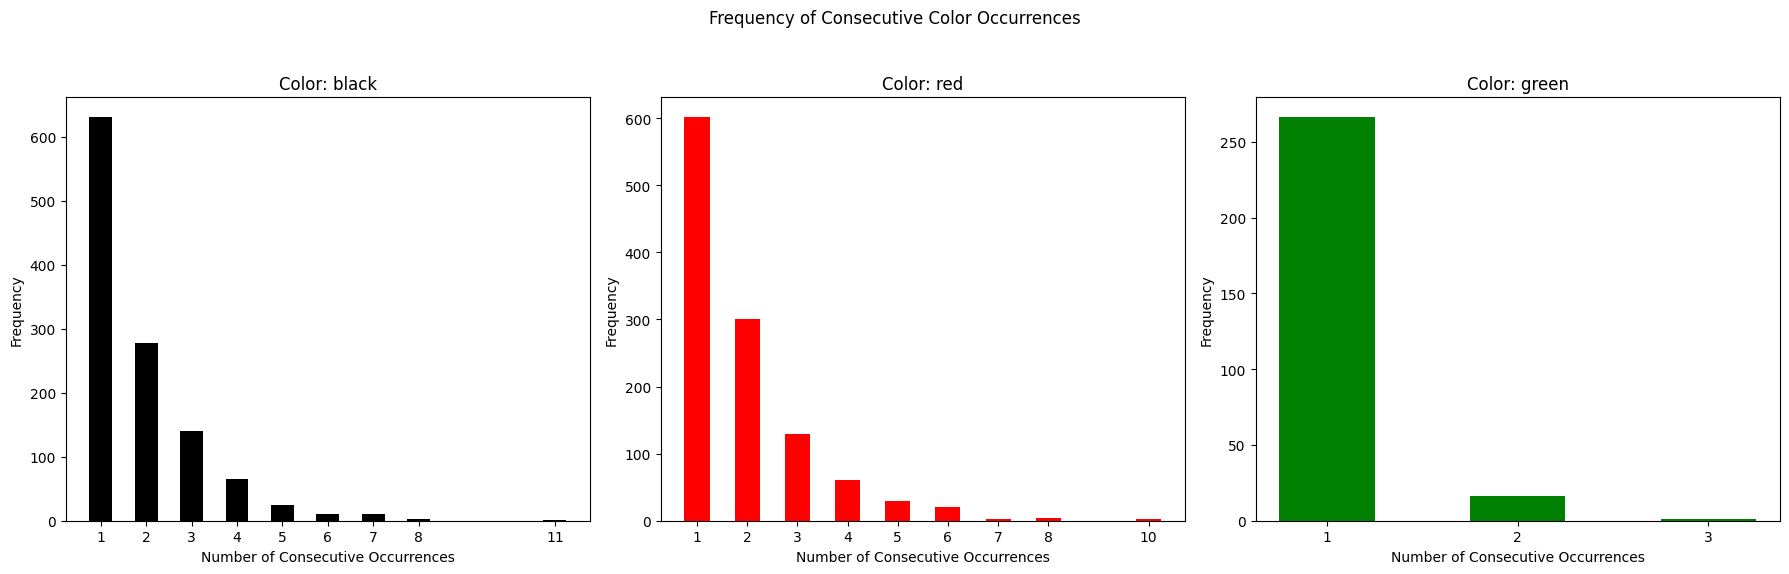


(2,)



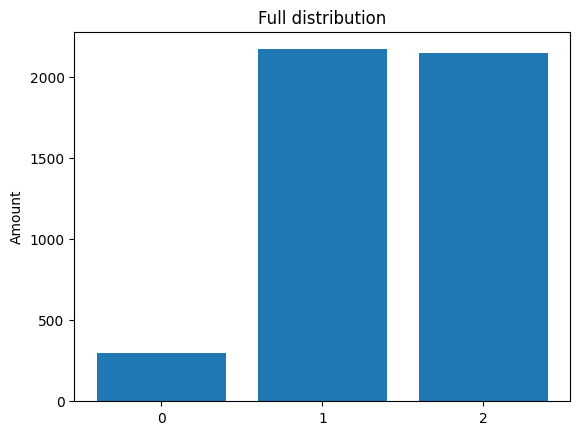

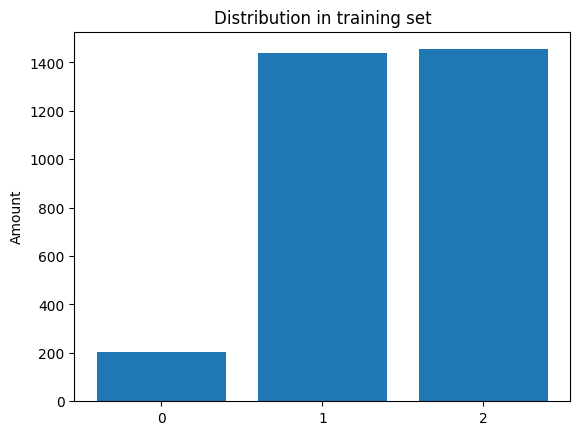

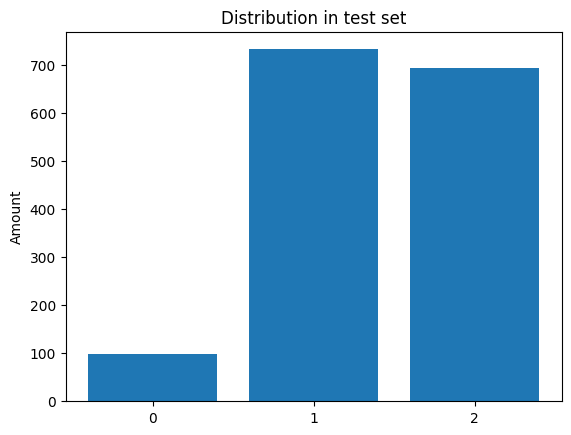

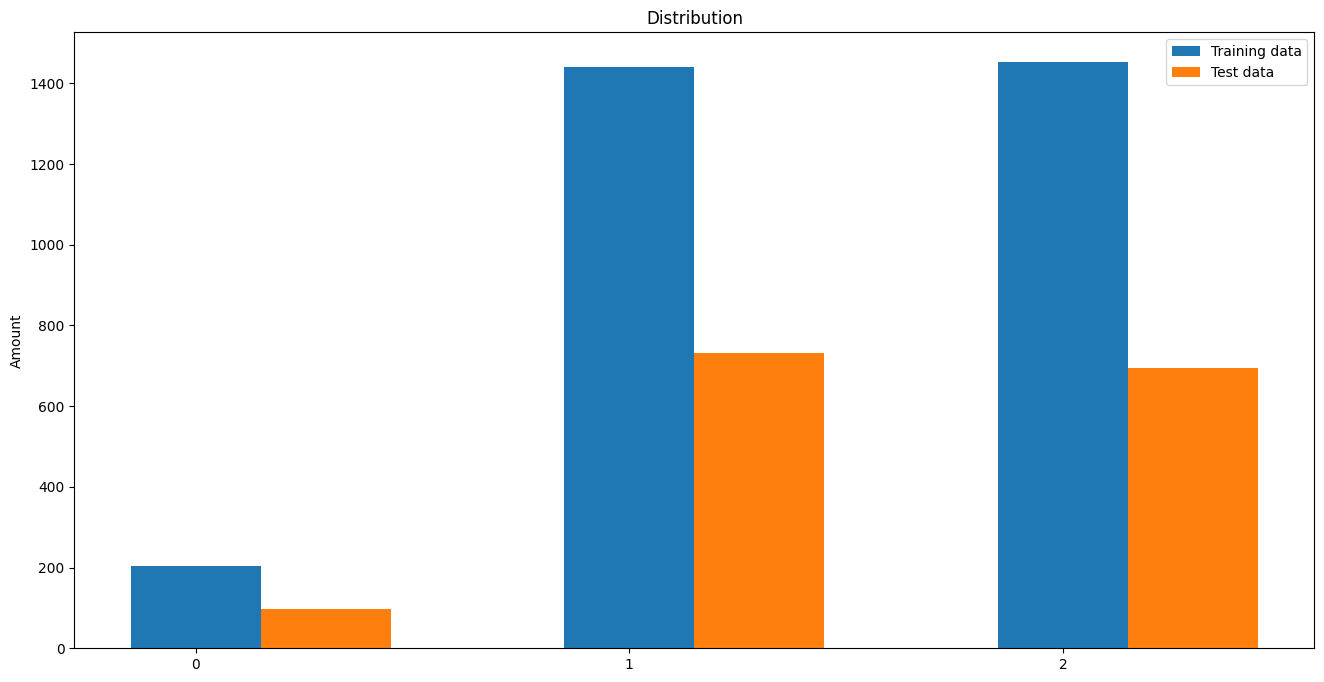


Example sequence from training set: [1 2] and its label: 2

Example sequence from training set: [1 0] and its label: 2


Random forest classifier accuracy: 46.00%
Random forest classifier accuracy: 45.41%




2024-05-09 18:32:47.349183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 18:32:47.349272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 18:32:47.349287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 18:32:47.822514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 18:32:47.822587: I external/local_xla/xla/stream_executor

Epoch 1/10


I0000 00:00:1715279568.931769  277373 service.cc:145] XLA service 0x7fabec0049d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715279568.931824  277373 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-09 18:32:48.998813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-09 18:32:49.226175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


91/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1472 - loss: 1.1719

I0000 00:00:1715279569.940156  277373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1577 - loss: 1.1686 - val_accuracy: 0.4554 - val_loss: 1.0510
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4734 - loss: 1.0105 - val_accuracy: 0.4554 - val_loss: 0.9268
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4712 - loss: 0.9197 - val_accuracy: 0.4554 - val_loss: 0.9047
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4593 - loss: 0.9049 - val_accuracy: 0.4554 - val_loss: 0.8973
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4624 - loss: 0.9067 - val_accuracy: 0.4554 - val_loss: 0.8935
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4622 - loss: 0.9062 - val_accuracy: 0.4554 - val_loss: 0.8912
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4623 - loss: 0.9101 - val_accuracy: 0.4554 - val_loss: 0.8901
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4563 - loss: 0.8915 - val_accuracy: 0.4554 - val_loss: 0.8893
Ep

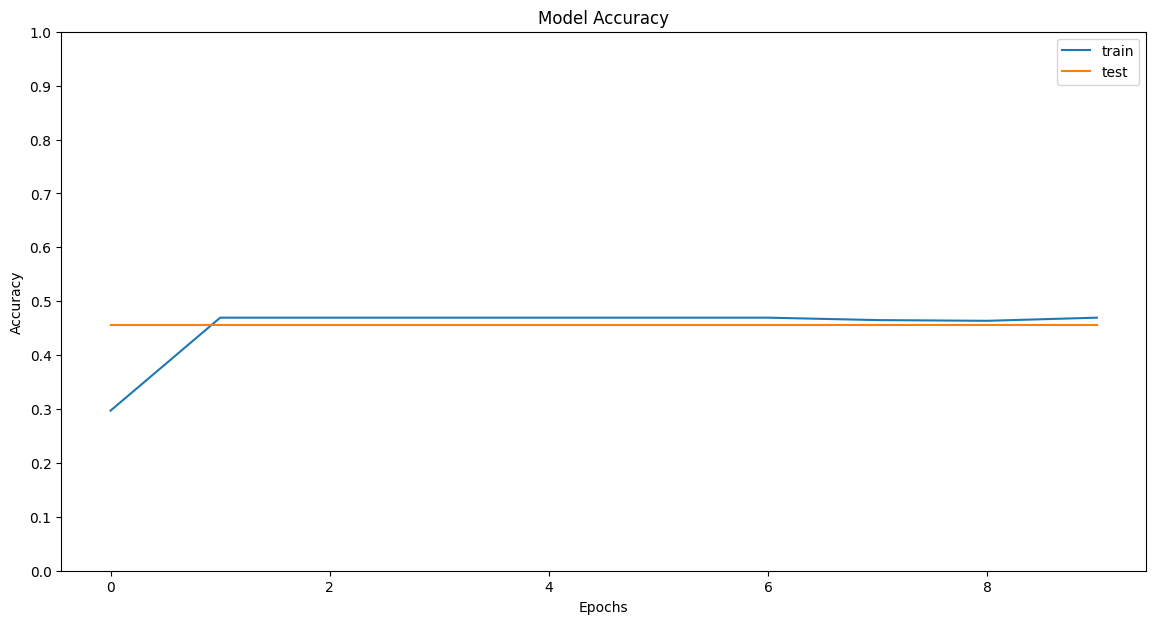

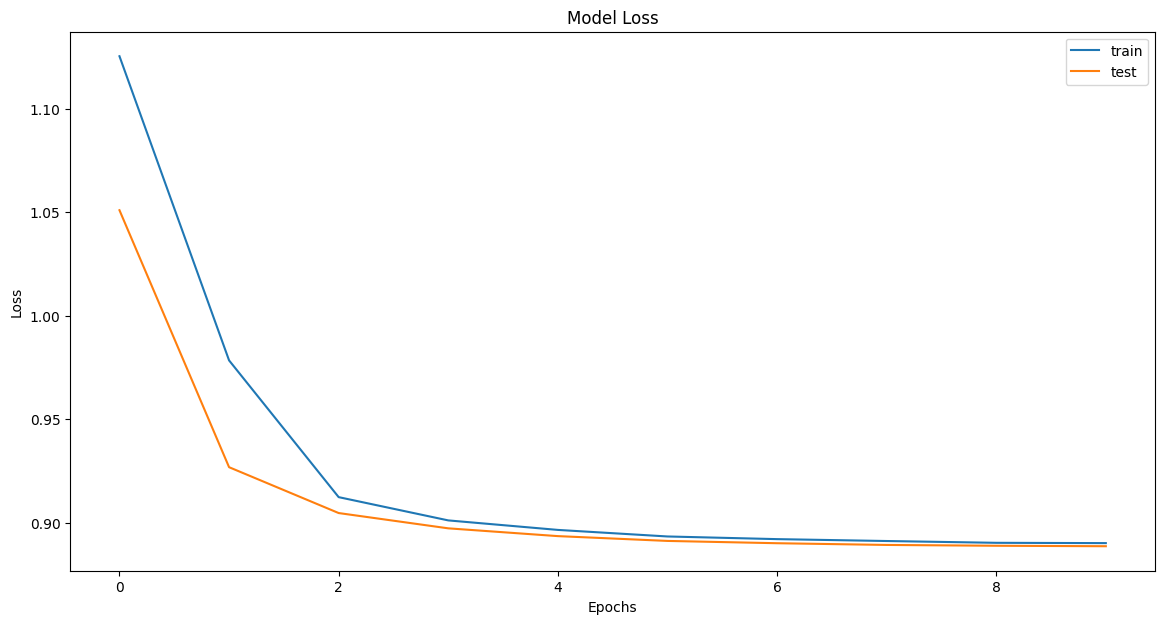

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 45.54%


For threshold set to 0.40, correctness is: 45.54%
For threshold set to 0.45, correctness is: 45.54%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 2, Epoch: 10, Accuracy: 0.46%

(5,)



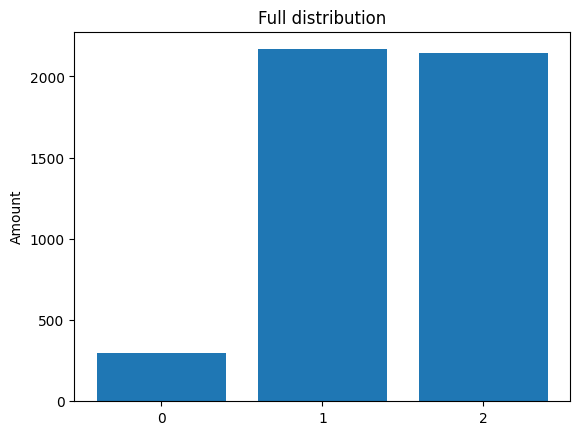

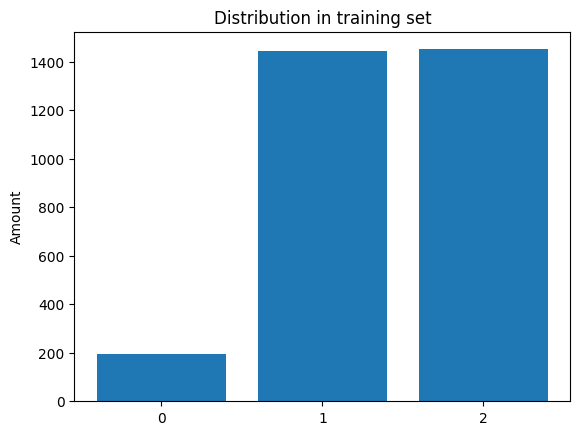

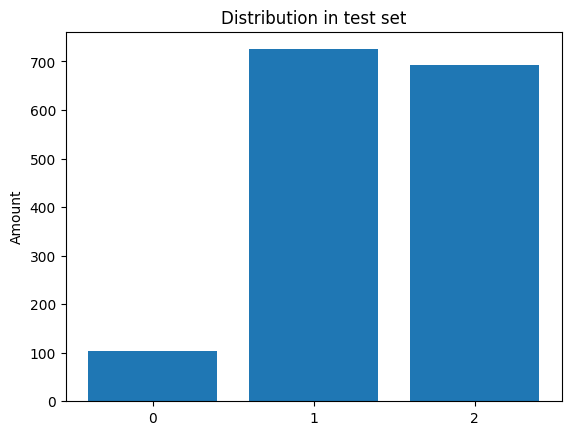

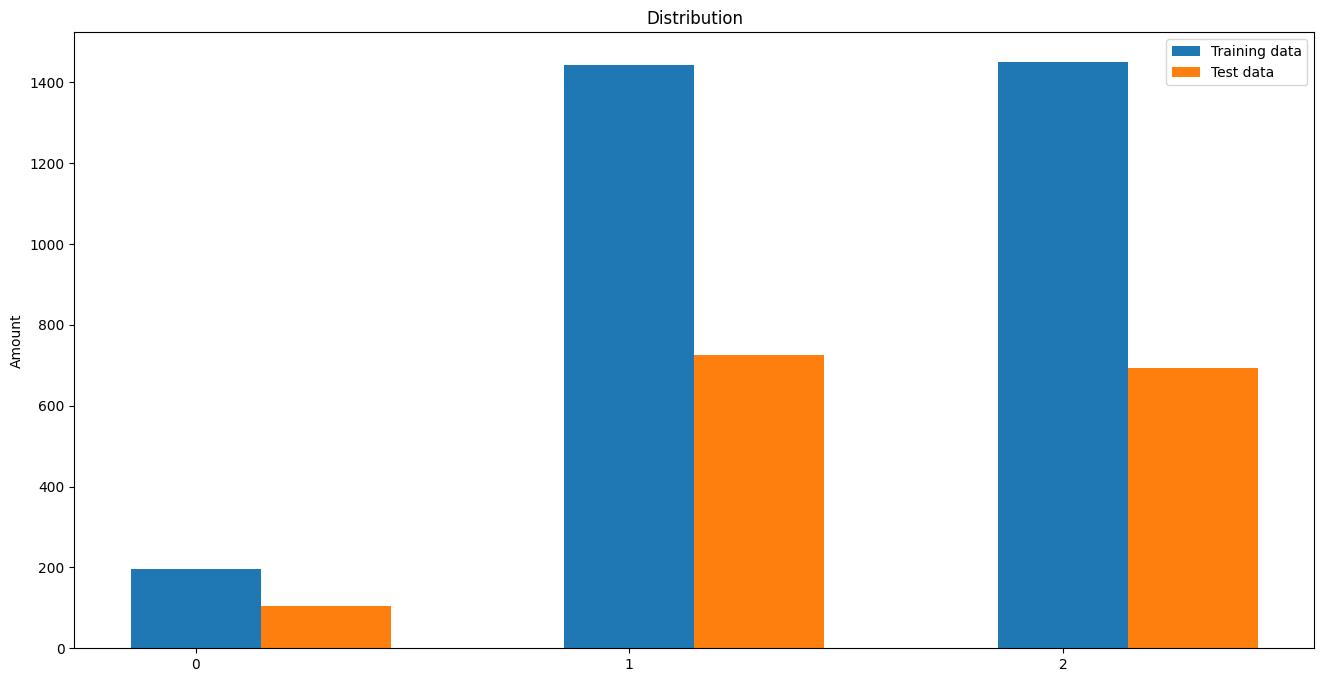


Example sequence from training set: [1 0 1 2 1] and its label: 1

Example sequence from training set: [2 2 1 1 1] and its label: 1


Random forest classifier accuracy: 46.98%
Random forest classifier accuracy: 44.55%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4683 - loss: 1.0144 - val_accuracy: 0.4763 - val_loss: 0.9220
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4673 - loss: 0.9093 - val_accuracy: 0.4763 - val_loss: 0.9074
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4643 - loss: 0.8999 - val_accuracy: 0.4763 - val_loss: 0.9014
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4664 - loss: 0.8952 - val_accuracy: 0.4737 - val_loss: 0.8983
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4821 - loss: 0.8757 - val_accuracy: 0.4763 - val_loss: 0.8966
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4793 - loss: 0.8880 - val_accuracy: 0.4553 - val_loss: 0.8956
Epoch 7/10
97/97 ━━━━━━

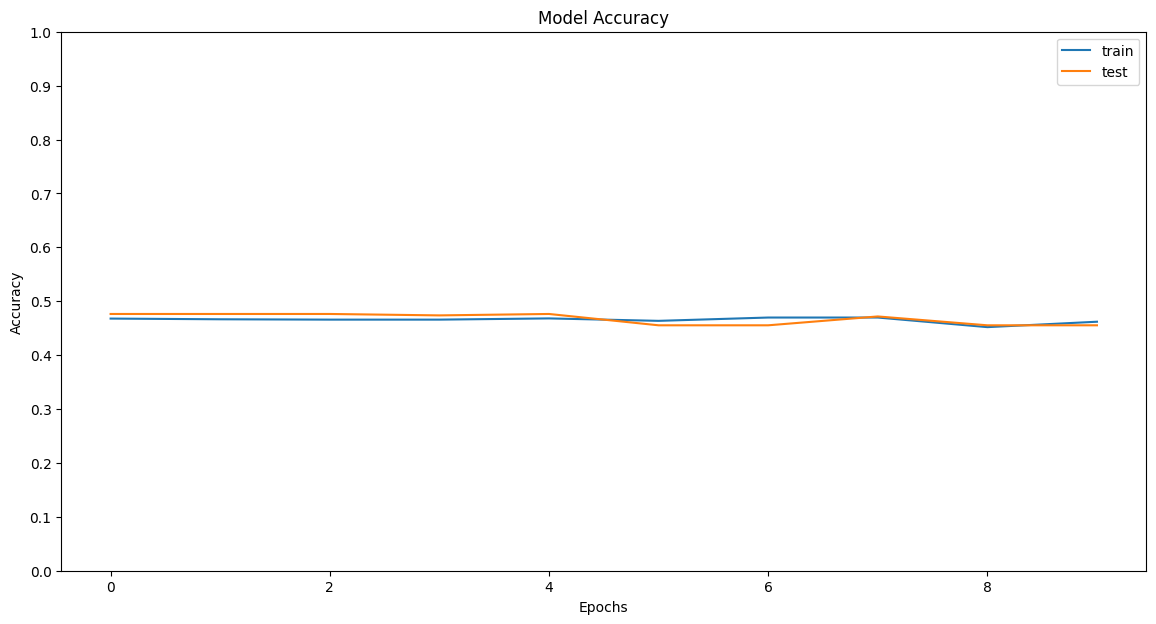

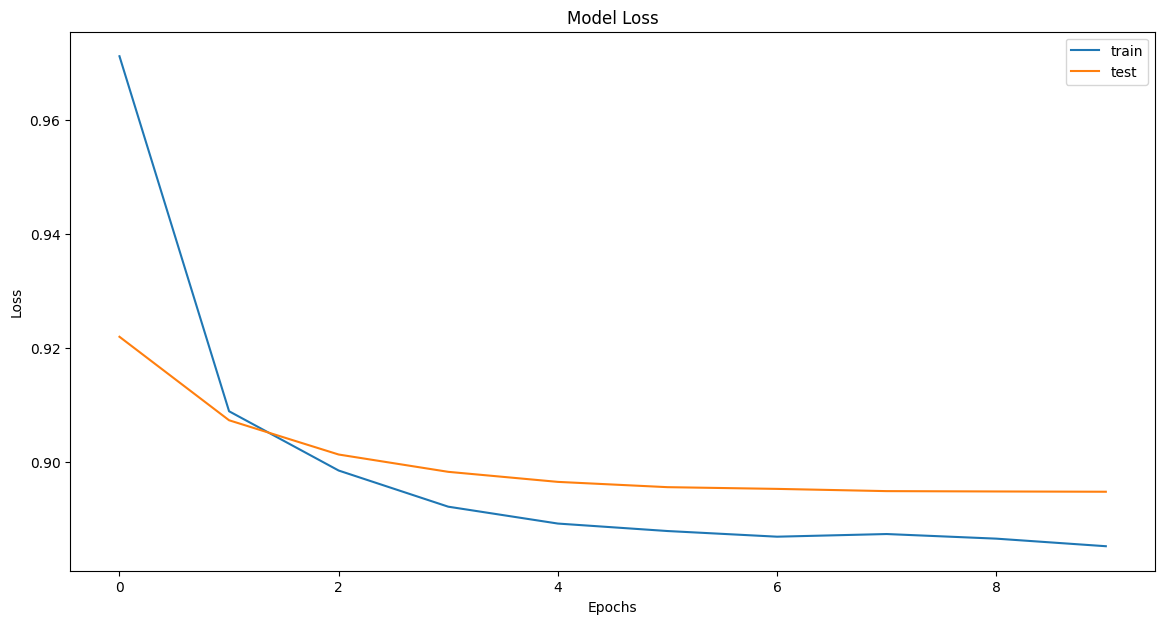

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 45.53%


For threshold set to 0.40, correctness is: 45.53%
For threshold set to 0.45, correctness is: 45.53%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 5, Epoch: 10, Accuracy: 0.46%

(10,)



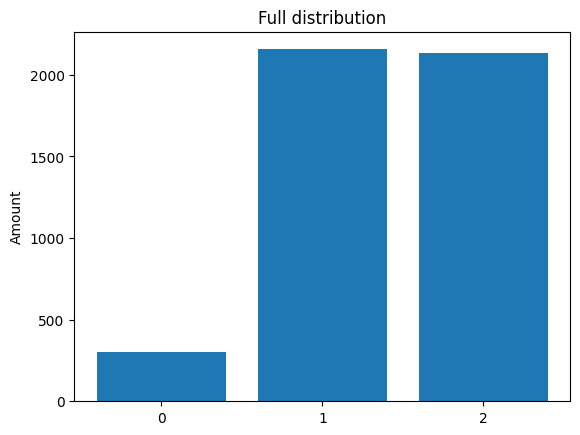

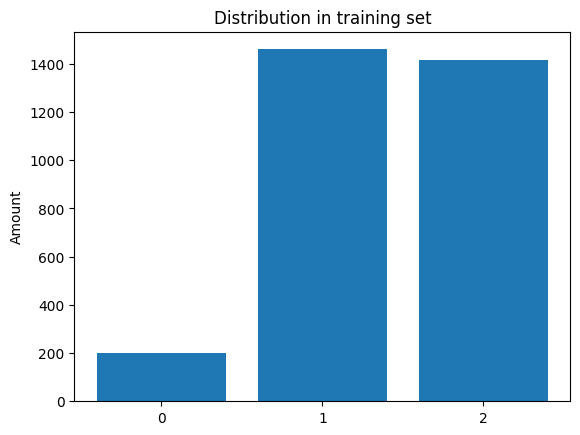

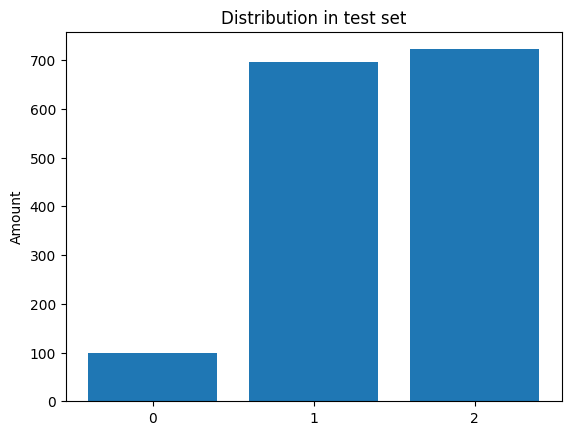

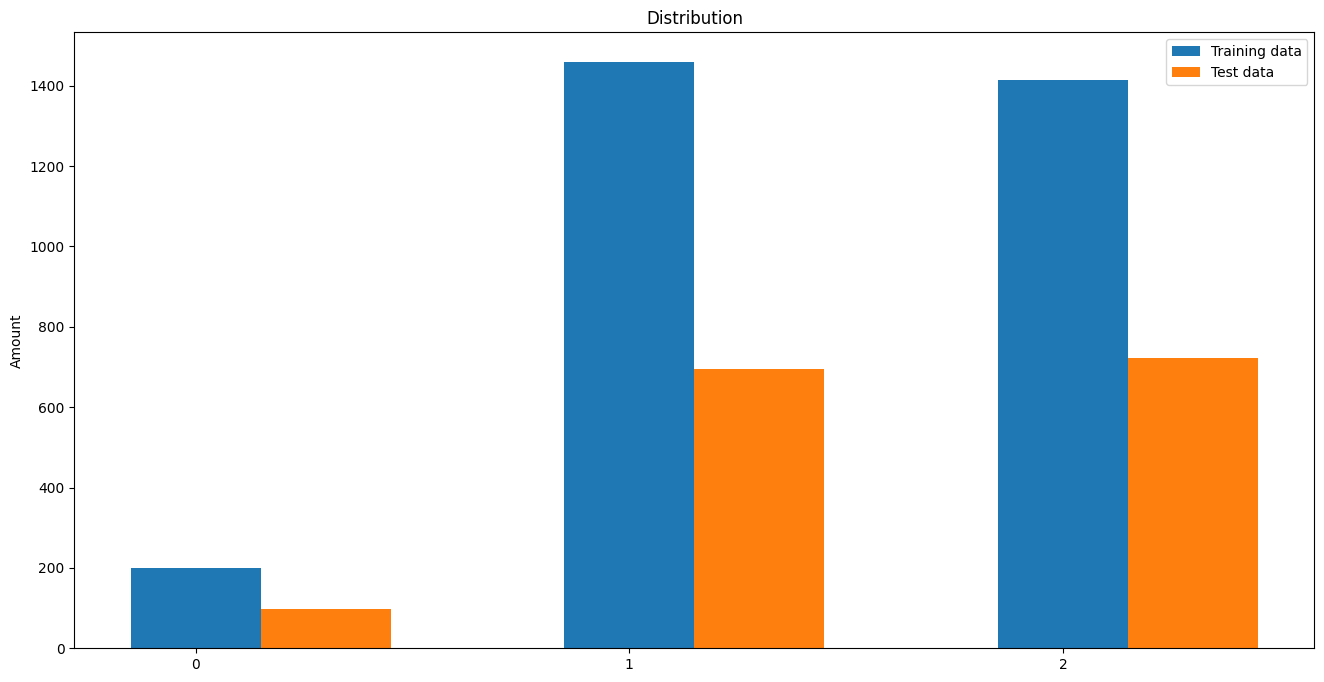


Example sequence from training set: [1 1 1 2 2 1 1 2 1 1] and its label: 1

Example sequence from training set: [2 2 2 1 2 2 2 2 1 2] and its label: 0


Random forest classifier accuracy: 44.59%
Random forest classifier accuracy: 46.37%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4767 - loss: 1.0478 - val_accuracy: 0.4551 - val_loss: 0.9590
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4890 - loss: 0.9475 - val_accuracy: 0.4584 - val_loss: 0.9294
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4732 - loss: 0.9265 - val_accuracy: 0.4703 - val_loss: 0.9095
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 0.9109 - val_accuracy: 0.4730 - val_loss: 0.9000
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4843 - loss: 0.9013 - val_accuracy: 0.4631 - val_loss: 0.8949
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4657 - loss: 0.8955 - val_accuracy: 0.4769 - val_loss: 0.8909
Epo

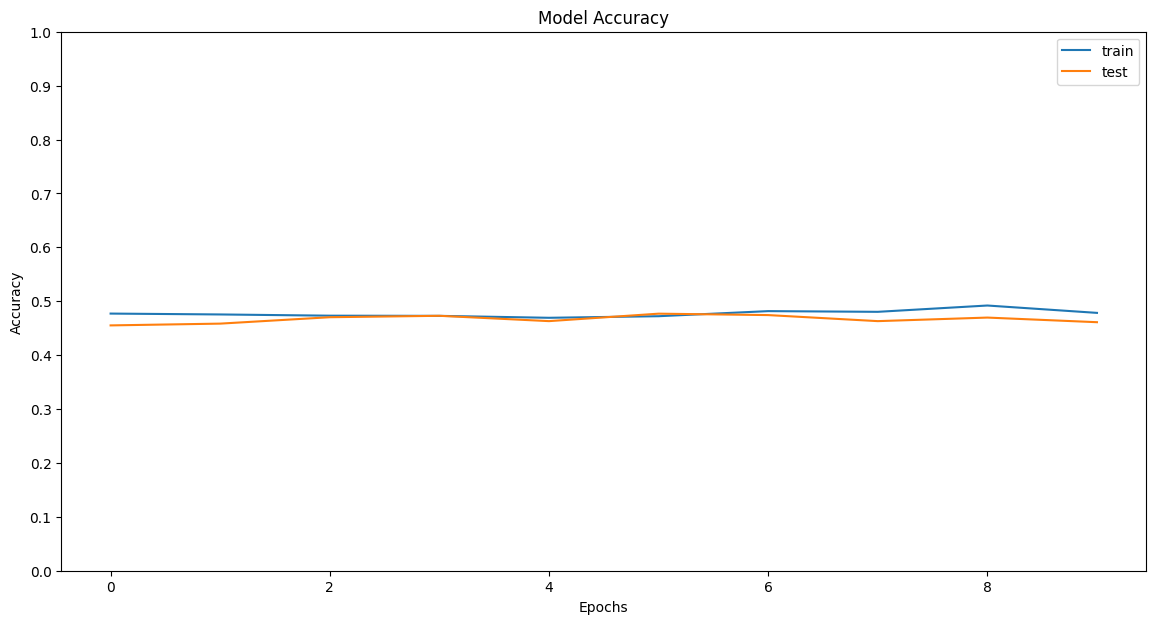

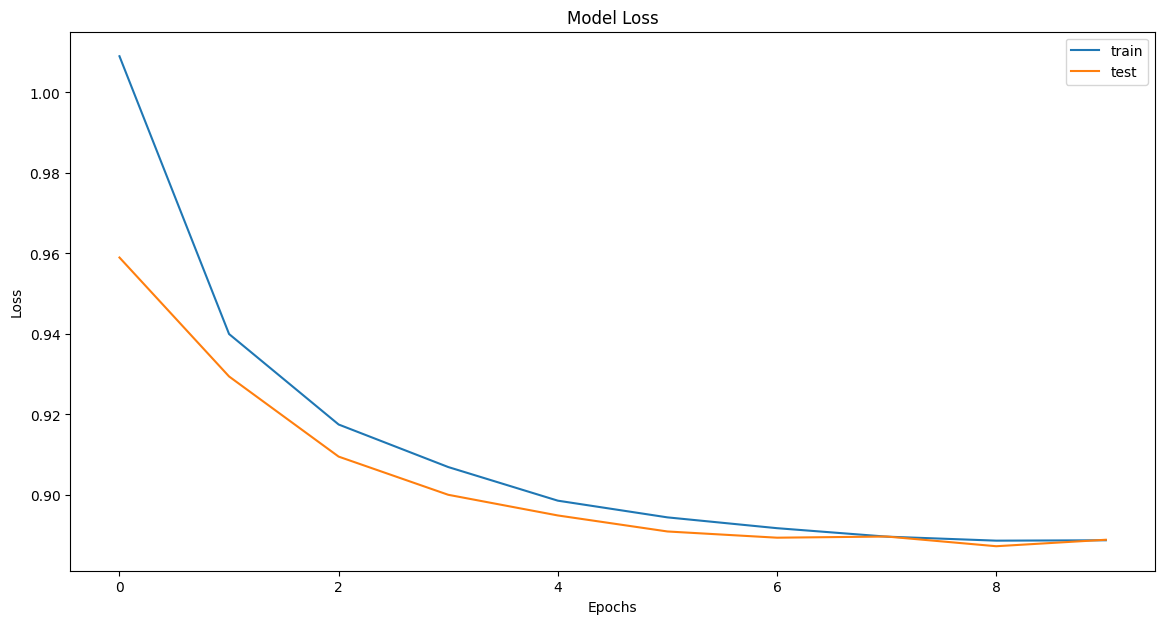

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Modal accuracy on test set: 46.11%


For threshold set to 0.40, correctness is: 46.11%
For threshold set to 0.45, correctness is: 46.11%
For threshold set to 0.50, correctness is: 48.81%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 10, Epoch: 10, Accuracy: 0.46%

Data from file: csgofastcom.csv


Example sequence: ['red', 'red', 'red', 'red', 'red', 'green', 'black', 'red', 'black', 'red', 'red', 'red']

black: Counter({1: 416, 2: 181, 3: 79, 4: 39, 6: 12, 5: 10, 7: 3, 8: 2, 9: 2})
red: Counter({1: 407, 2: 178, 3: 78, 4: 42, 5: 23, 6: 12, 7: 2, 9: 1, 8: 1})
green: Counter({1: 165, 2: 6})




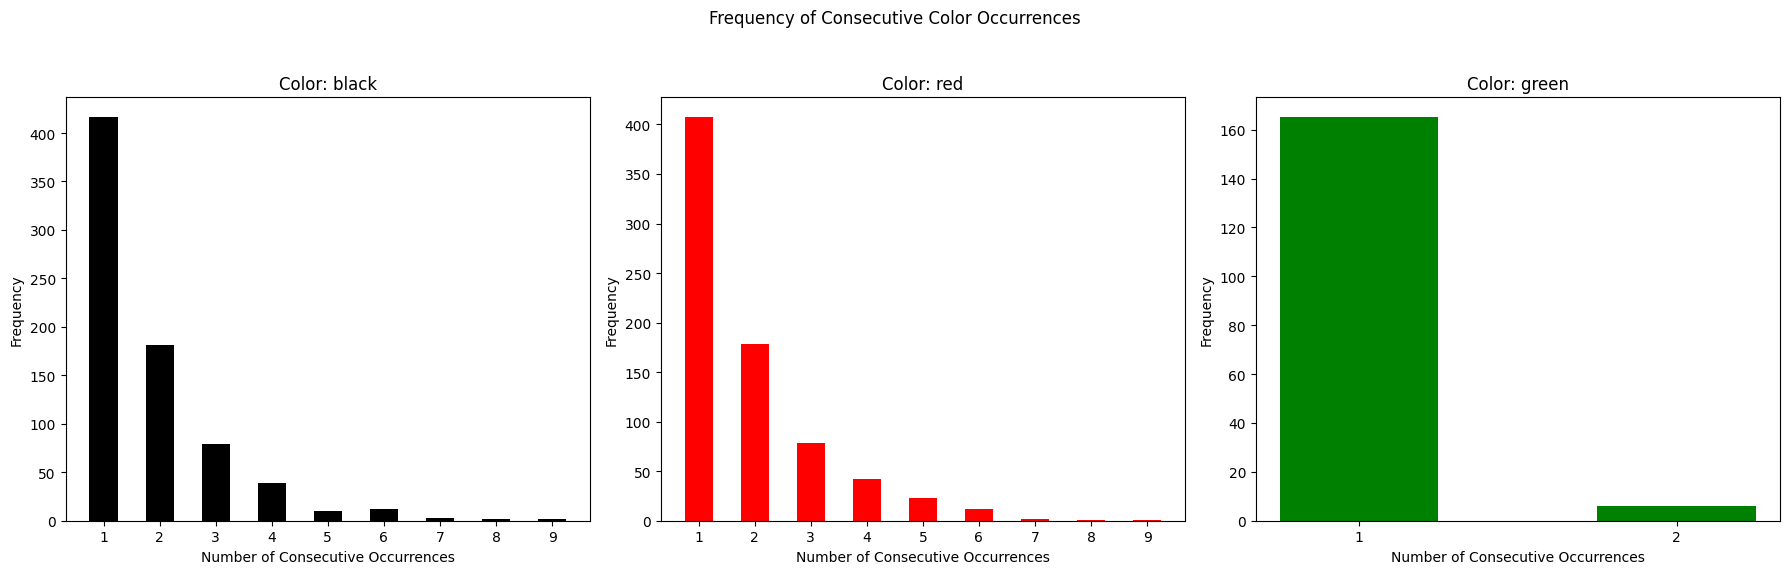


(2,)



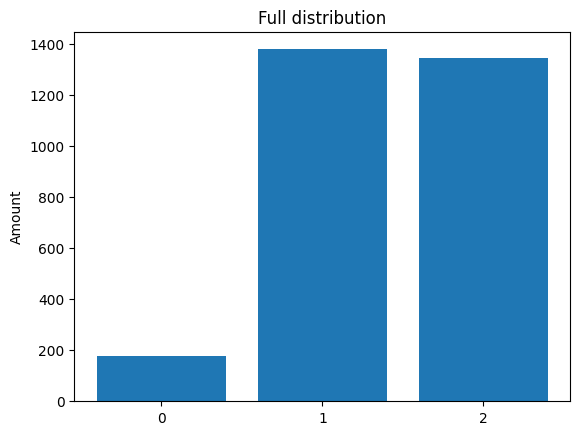

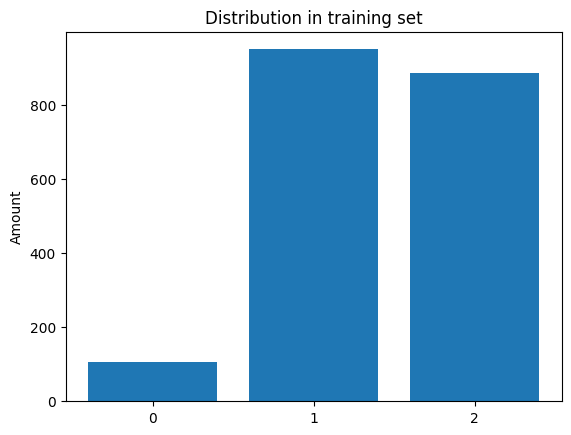

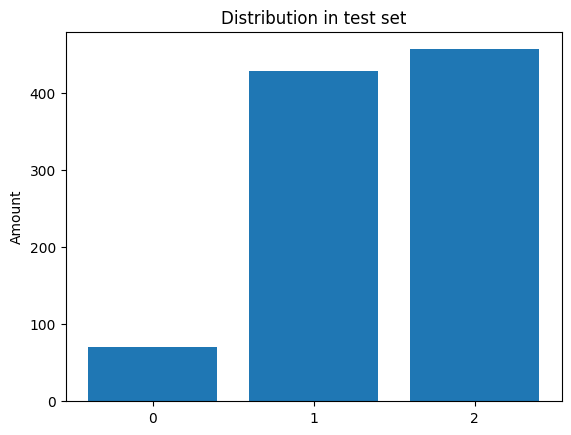

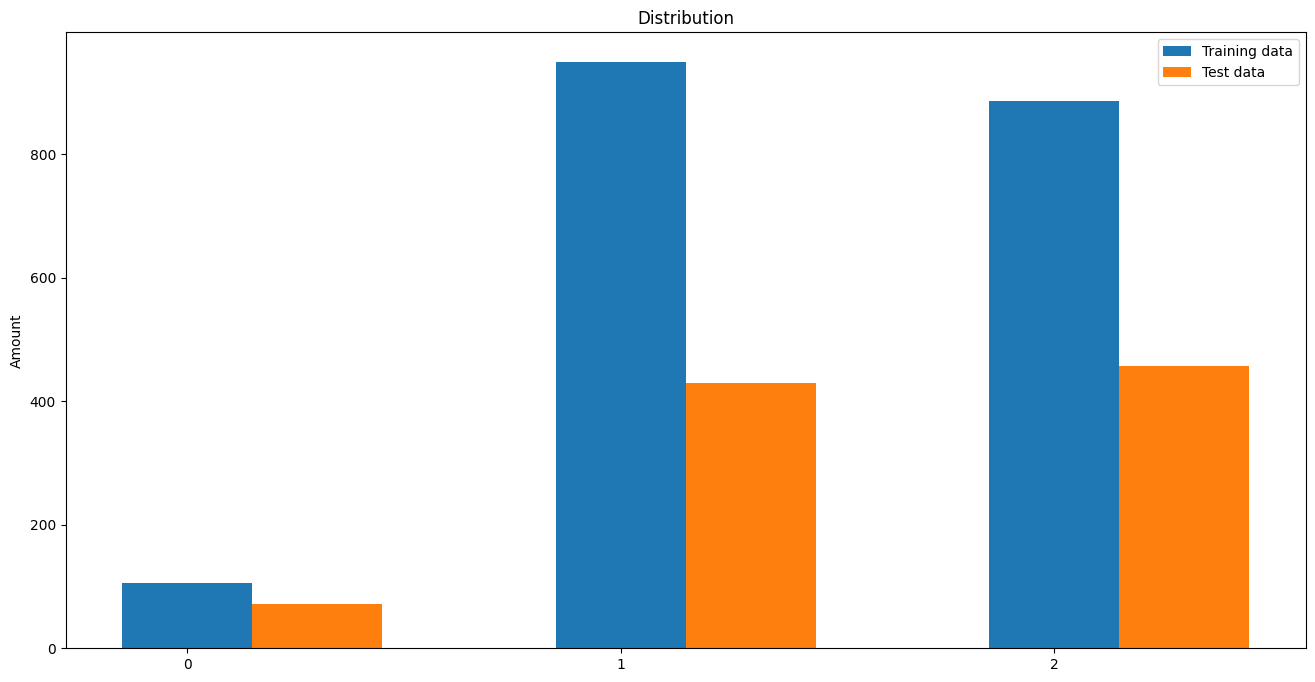


Example sequence from training set: [0 1] and its label: 0

Example sequence from training set: [2 1] and its label: 0


Random forest classifier accuracy: 45.56%
Random forest classifier accuracy: 45.45%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4670 - loss: 1.0919 - val_accuracy: 0.4775 - val_loss: 1.0046
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4812 - loss: 0.9685 - val_accuracy: 0.4775 - val_loss: 0.9419
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4589 - loss: 0.9175 - val_accuracy: 0.4775 - val_loss: 0.9285
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4749 - loss: 0.9058 - val_accuracy: 0.4765 - val_loss: 0.9207
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4802 - loss: 0.8932 - val_accuracy: 0.4483 - val_loss: 0.9158
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4965 - loss: 0.8786 - val_accuracy: 0.4483 - val_loss: 0.9123
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━

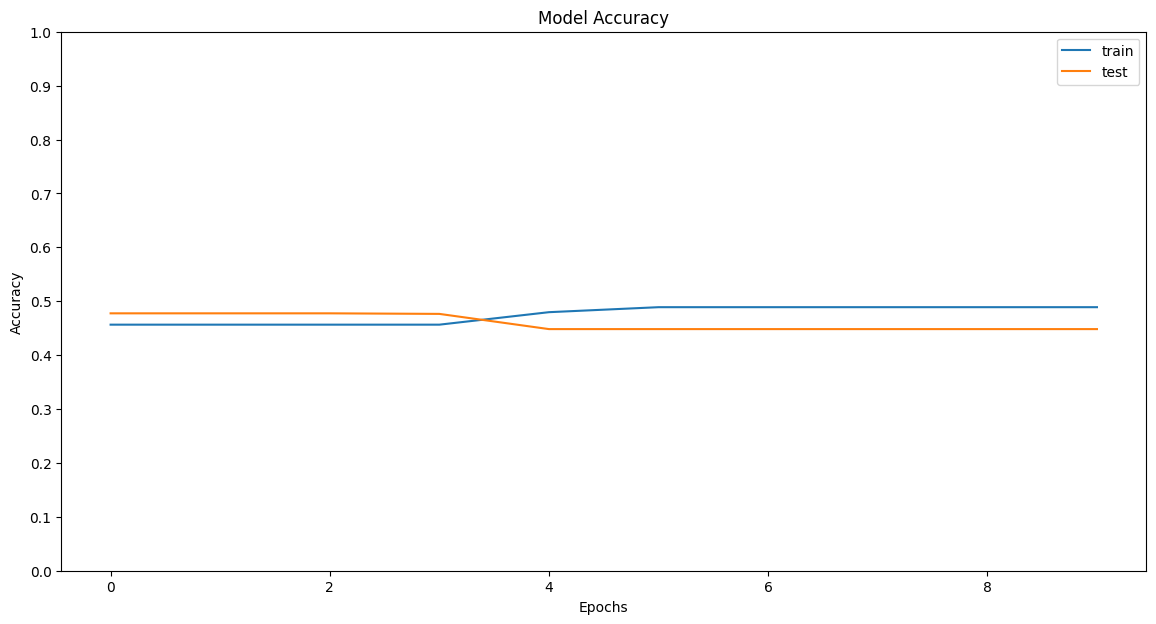

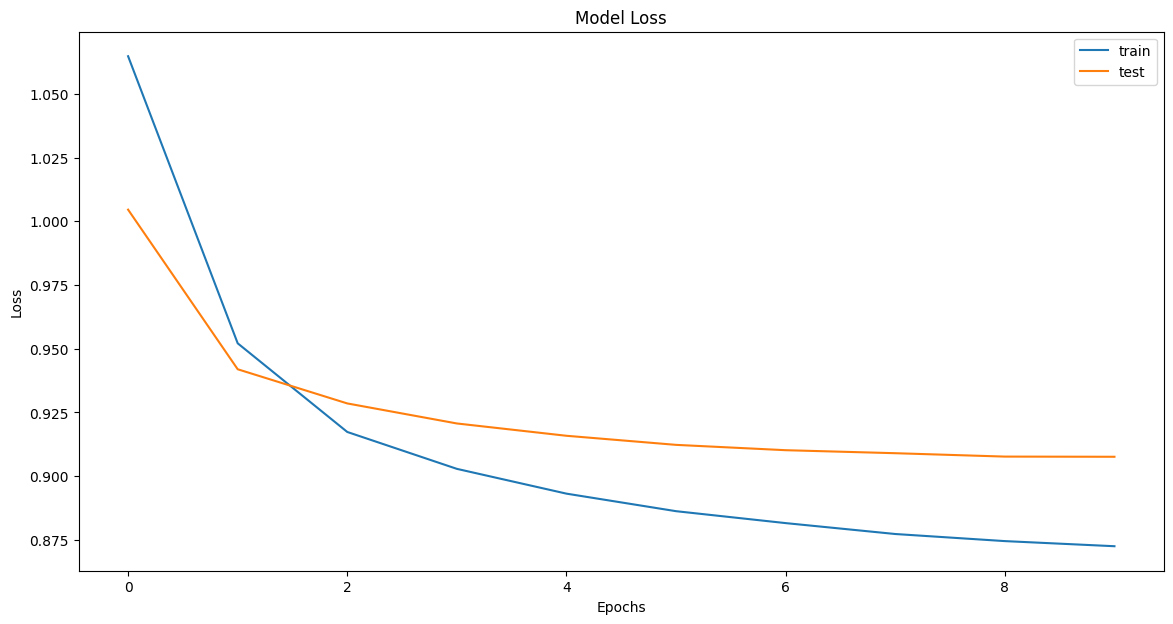

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 44.83%


For threshold set to 0.40, correctness is: 44.83%
For threshold set to 0.45, correctness is: 44.83%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 2, Epoch: 10, Accuracy: 0.45%

(5,)



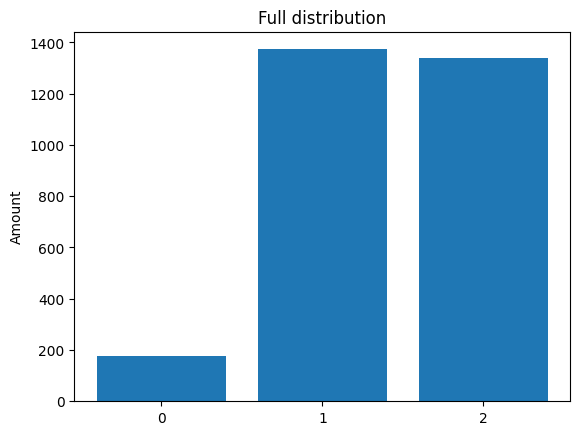

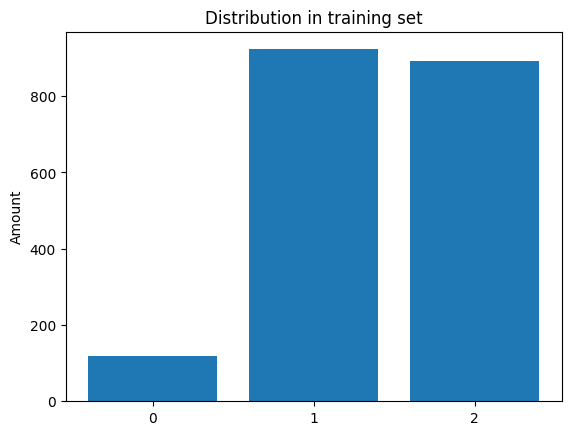

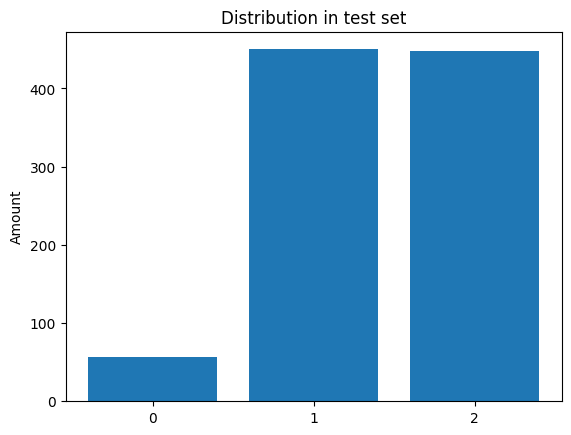

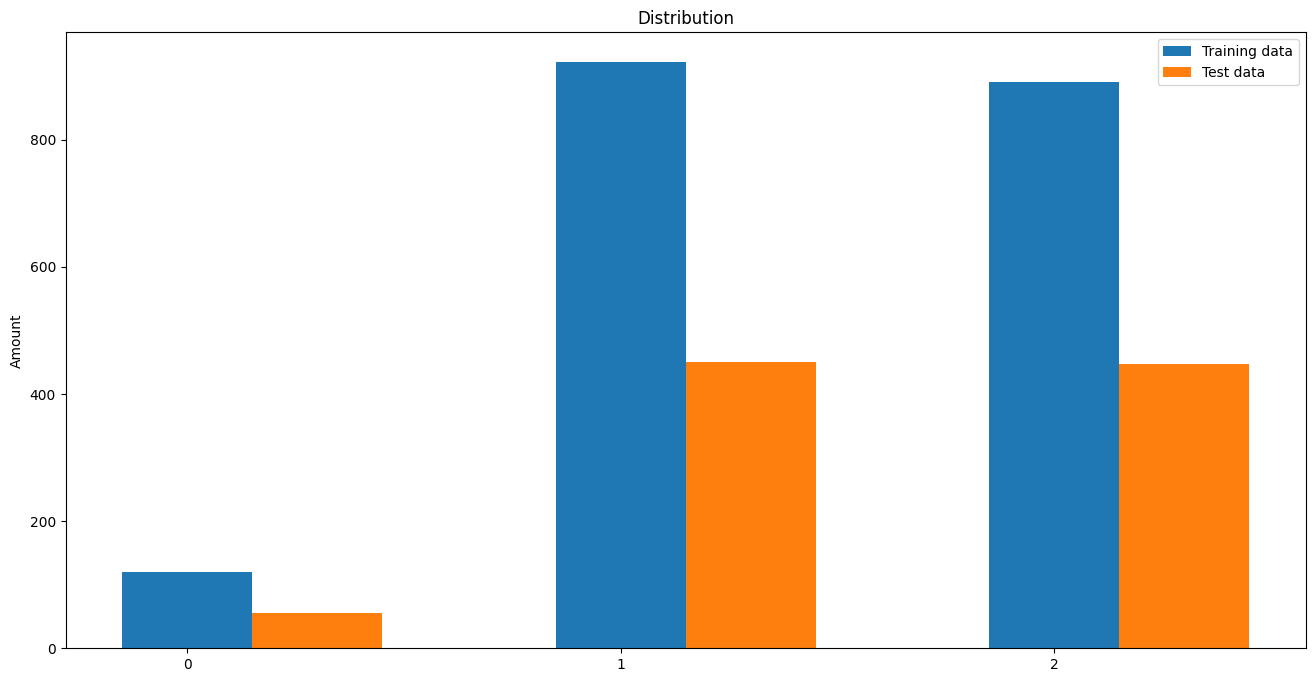


Example sequence from training set: [1 1 2 0 0] and its label: 2

Example sequence from training set: [1 1 2 2 2] and its label: 2


Random forest classifier accuracy: 45.91%
Random forest classifier accuracy: 48.64%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4693 - loss: 1.0734 - val_accuracy: 0.4696 - val_loss: 0.9647
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4448 - loss: 0.9525 - val_accuracy: 0.4727 - val_loss: 0.9219
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4768 - loss: 0.9135 - val_accuracy: 0.4717 - val_loss: 0.9079
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4685 - loss: 0.9028 - val_accuracy: 0.4717 - val_loss: 0.8985
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4729 - loss: 0.9060 - val_accuracy: 0.4727 - val_loss: 0.8922
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4852 - loss: 0.8935 - val_accuracy: 0.4727 - val_loss: 0.8879
Epoch 7/10
61/61 ━━━━━━

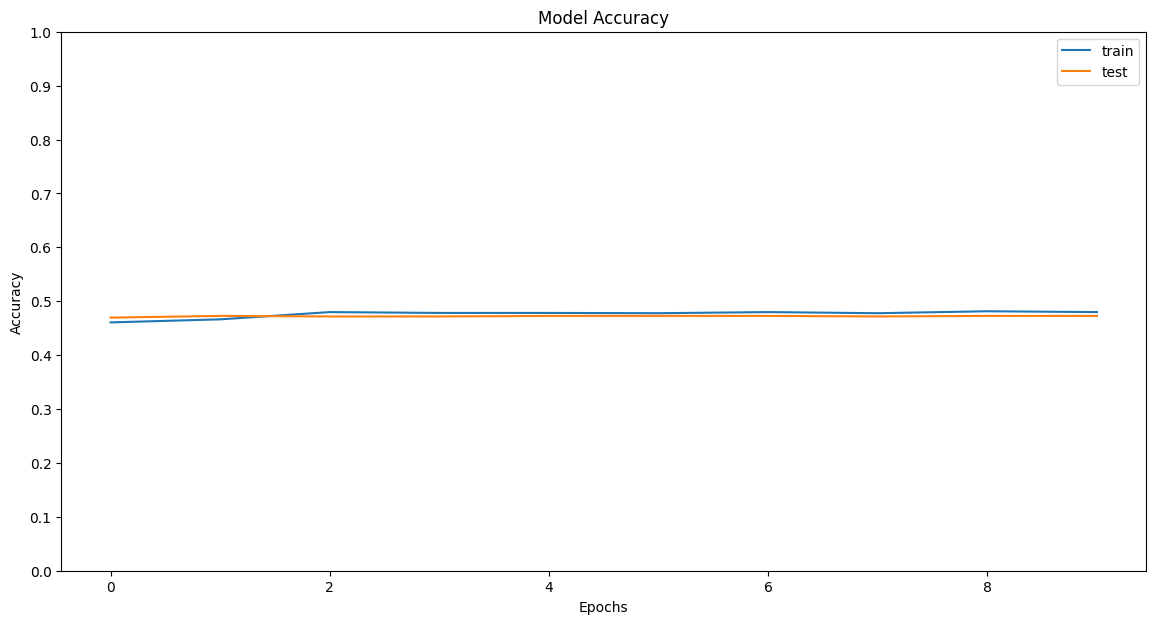

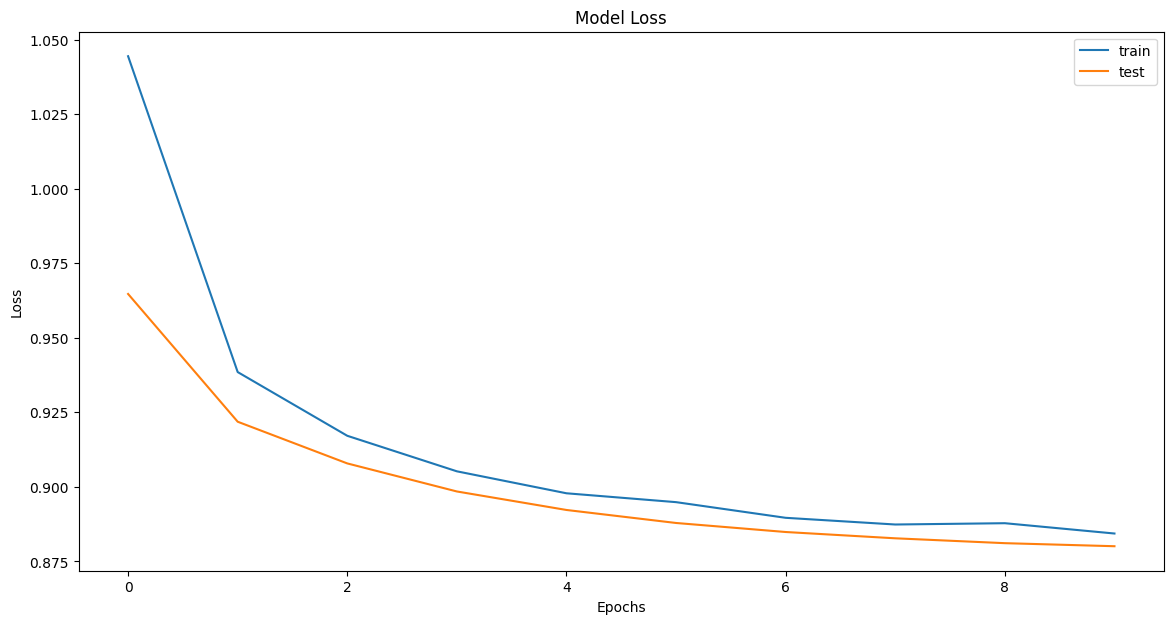

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 47.27%


For threshold set to 0.40, correctness is: 47.27%
For threshold set to 0.45, correctness is: 47.27%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 5, Epoch: 10, Accuracy: 0.47%

(10,)



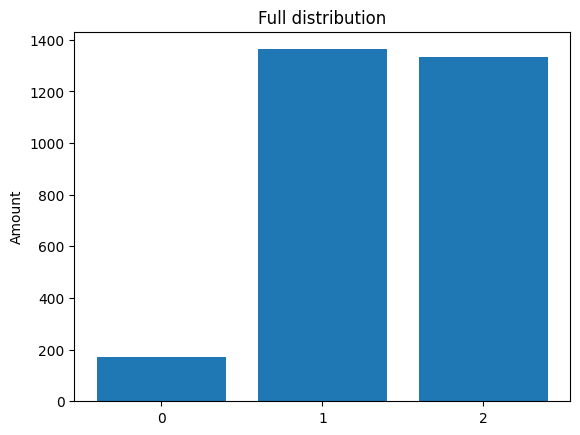

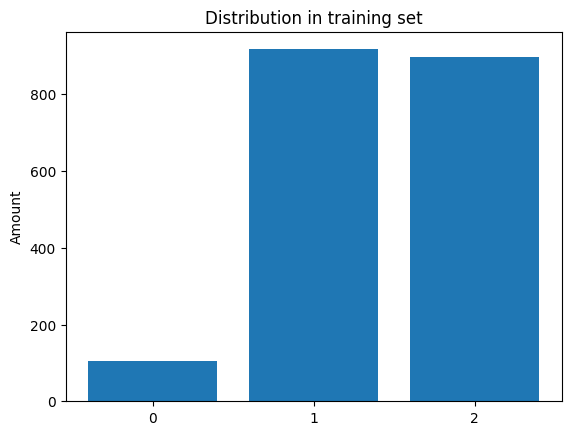

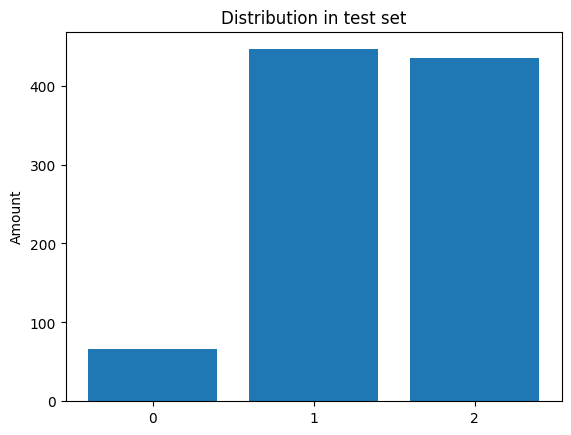

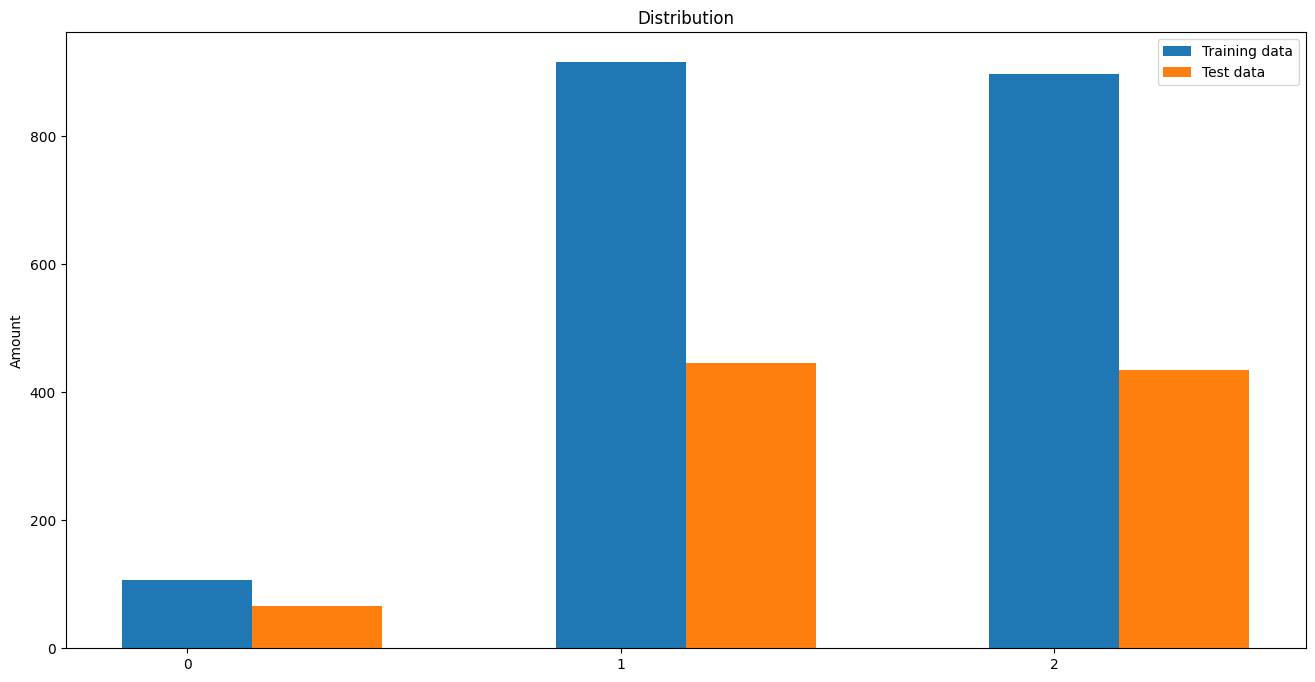


Example sequence from training set: [2 1 1 1 1 2 0 2 2 2] and its label: 1

Example sequence from training set: [2 1 2 1 1 1 1 1 1 2] and its label: 1


Random forest classifier accuracy: 47.10%
Random forest classifier accuracy: 46.57%


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4160 - loss: 1.0747 - val_accuracy: 0.4710 - val_loss: 0.9753
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4732 - loss: 0.9519 - val_accuracy: 0.4710 - val_loss: 0.9199
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4780 - loss: 0.8992 - val_accuracy: 0.4710 - val_loss: 0.9078
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4600 - loss: 0.8989 - val_accuracy: 0.4710 - val_loss: 0.9026
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4705 - loss: 0.8900 - val_accuracy: 0.4710 - val_loss: 0.8997
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4747 - loss: 0.8821 - val_accuracy: 0.4710 - val_loss: 0.8978
Epo

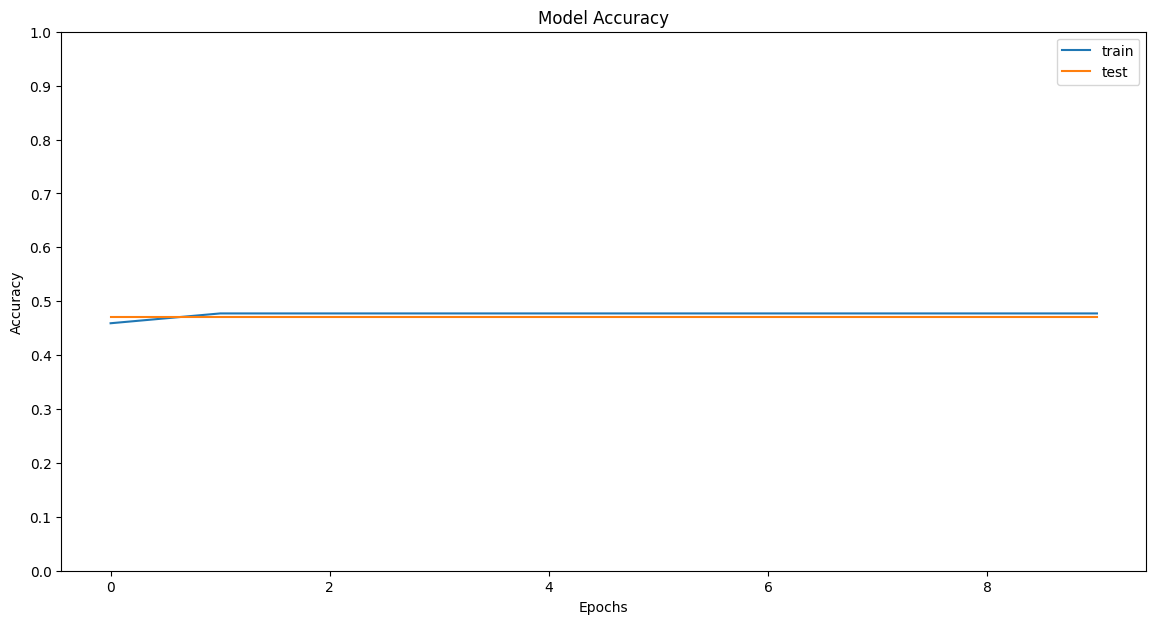

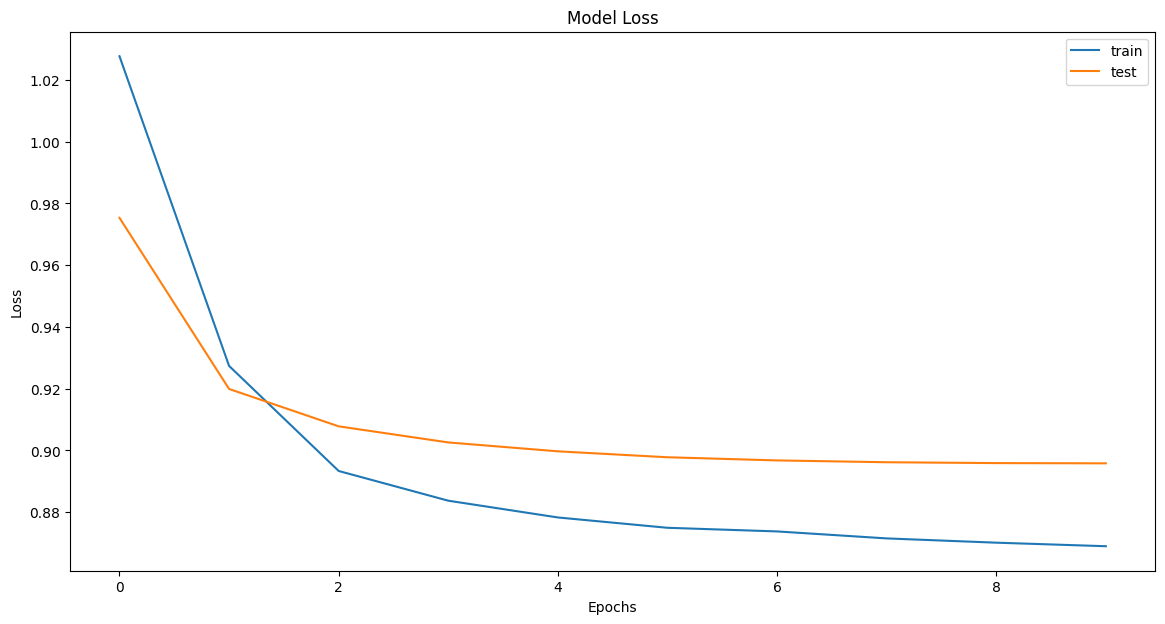

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Modal accuracy on test set: 47.10%


For threshold set to 0.40, correctness is: 47.10%
For threshold set to 0.45, correctness is: 47.10%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 10, Epoch: 10, Accuracy: 0.47%

Data from file: plgbet.csv


Example sequence: ['red', 'red', 'black', 'black', 'red', 'black', 'red', 'red', 'black', 'red', 'red', 'red']

black: Counter({1: 387, 2: 164, 3: 90, 4: 40, 5: 19, 7: 6, 6: 5, 8: 2, 9: 1})
red: Counter({1: 366, 2: 180, 3: 99, 4: 29, 5: 13, 6: 9, 7: 4, 10: 2, 8: 1})
green: Counter({1: 171, 2: 6})




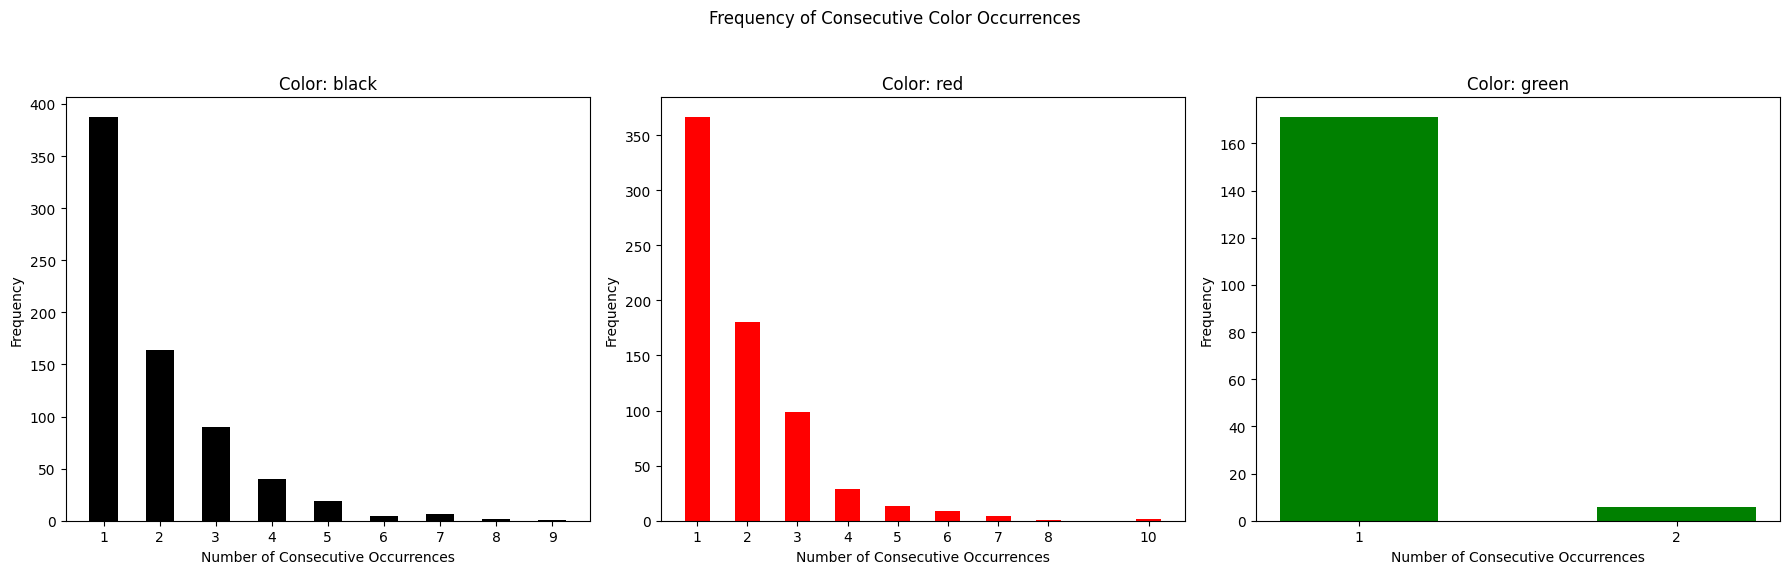


(2,)



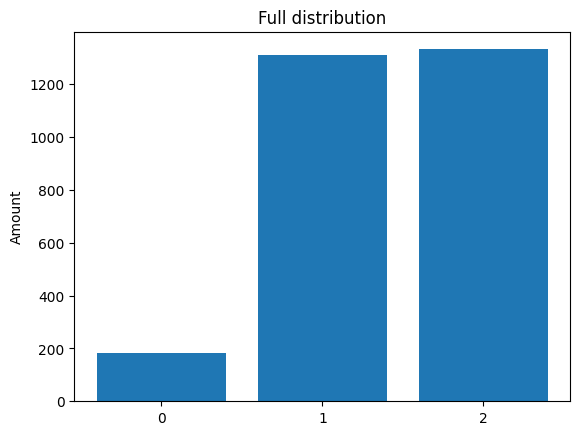

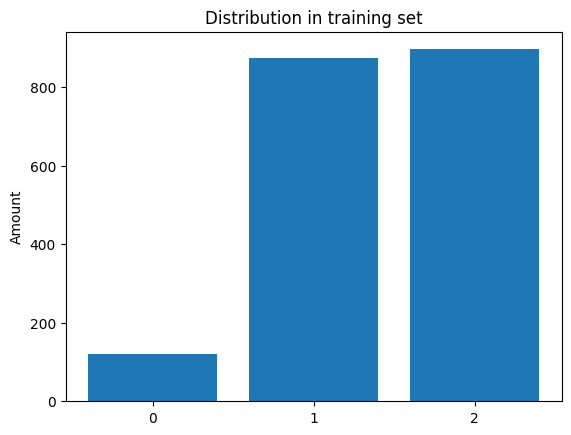

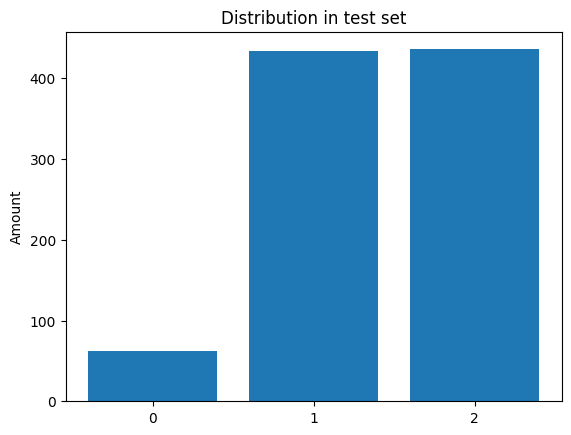

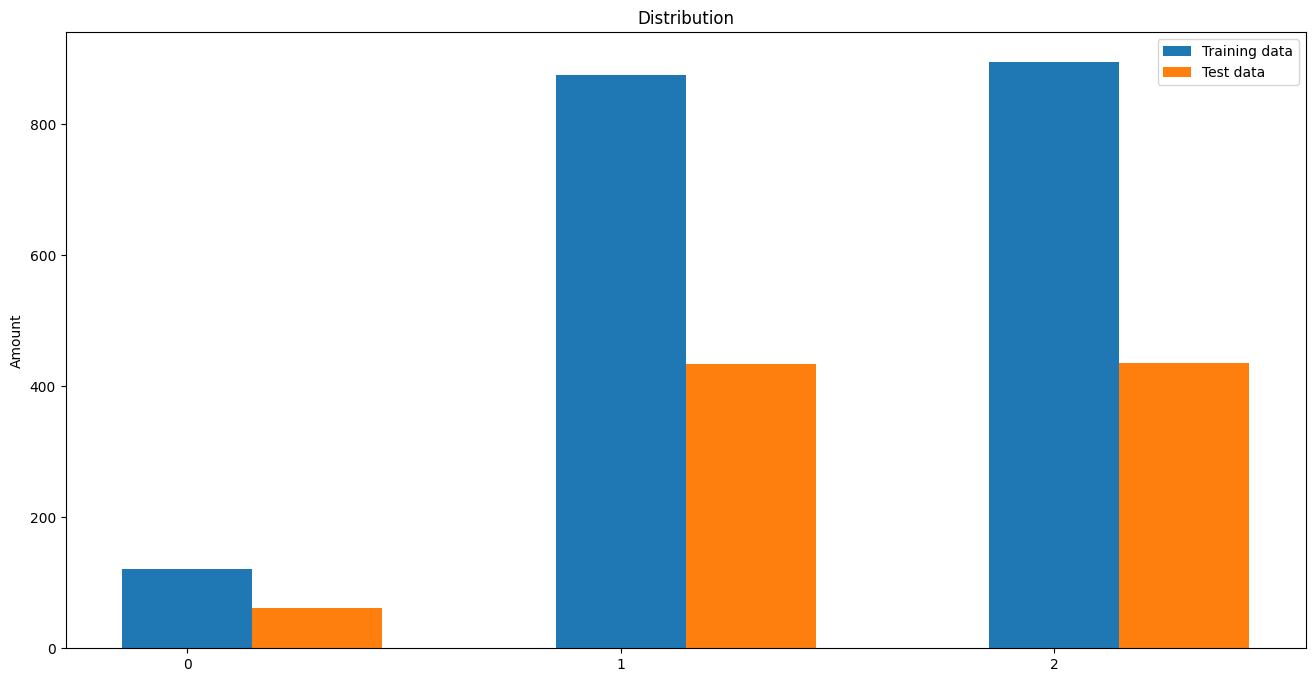


Example sequence from training set: [2 2] and its label: 2

Example sequence from training set: [1 0] and its label: 1


Random forest classifier accuracy: 44.10%
Random forest classifier accuracy: 45.17%


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2265 - loss: 1.1162 - val_accuracy: 0.4657 - val_loss: 0.9860
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4711 - loss: 0.9665 - val_accuracy: 0.4657 - val_loss: 0.9438
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4515 - loss: 0.9391 - val_accuracy: 0.4657 - val_loss: 0.9248
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4583 - loss: 0.9180 - val_accuracy: 0.4657 - val_loss: 0.9131
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4820 - loss: 0.8968 - val_accuracy: 0.4657 - val_loss: 0.9056
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4781 - loss: 0.8935 - val_accuracy: 0.4646 - val_loss: 0.9007
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━

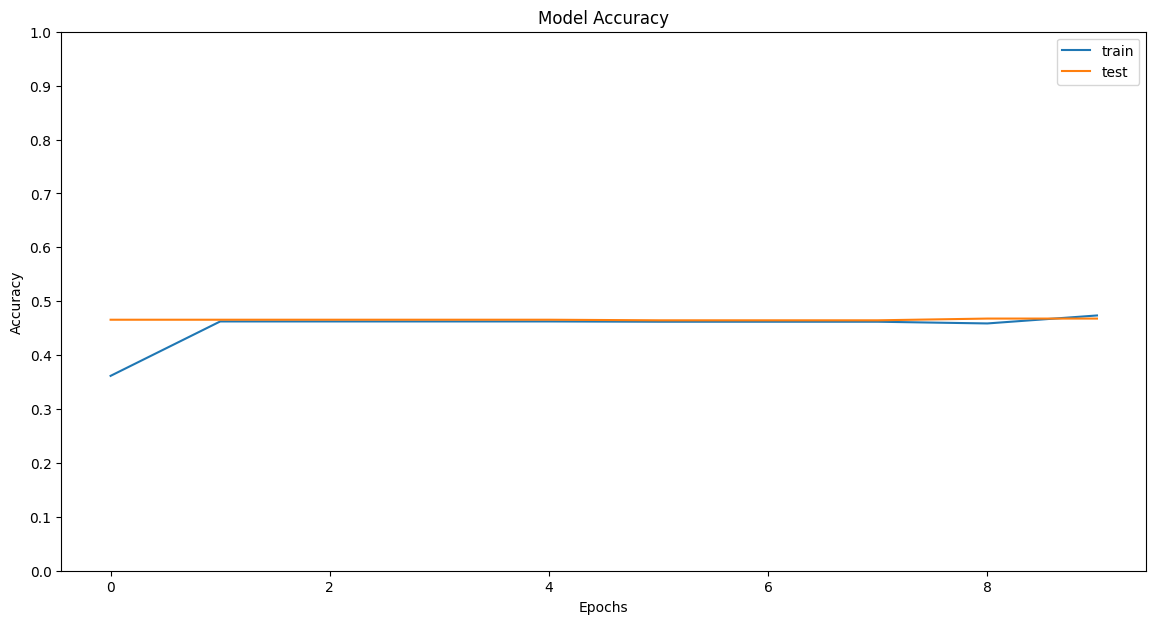

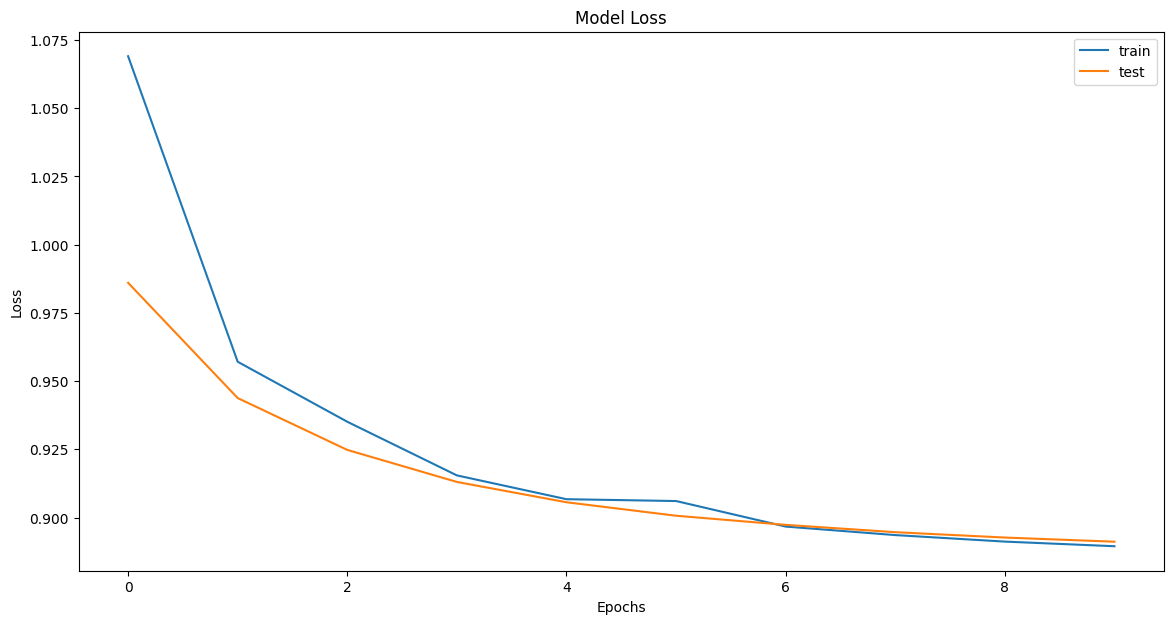

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 46.78%


For threshold set to 0.40, correctness is: 46.78%
For threshold set to 0.45, correctness is: 46.78%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 2, Epoch: 10, Accuracy: 0.47%

(5,)



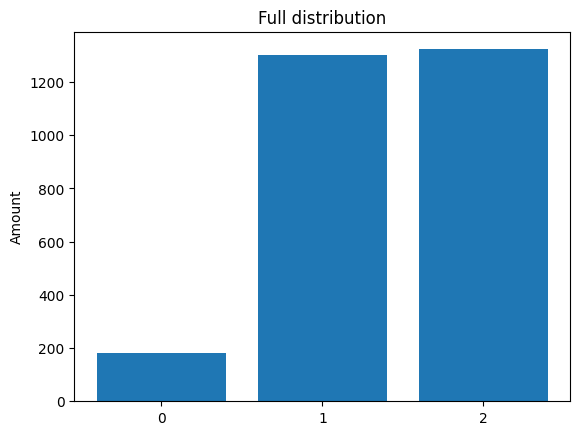

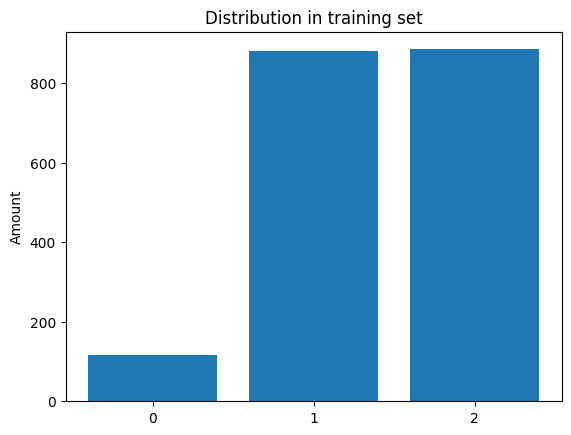

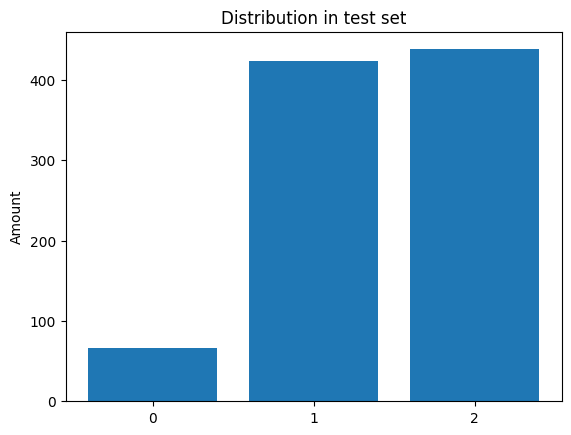

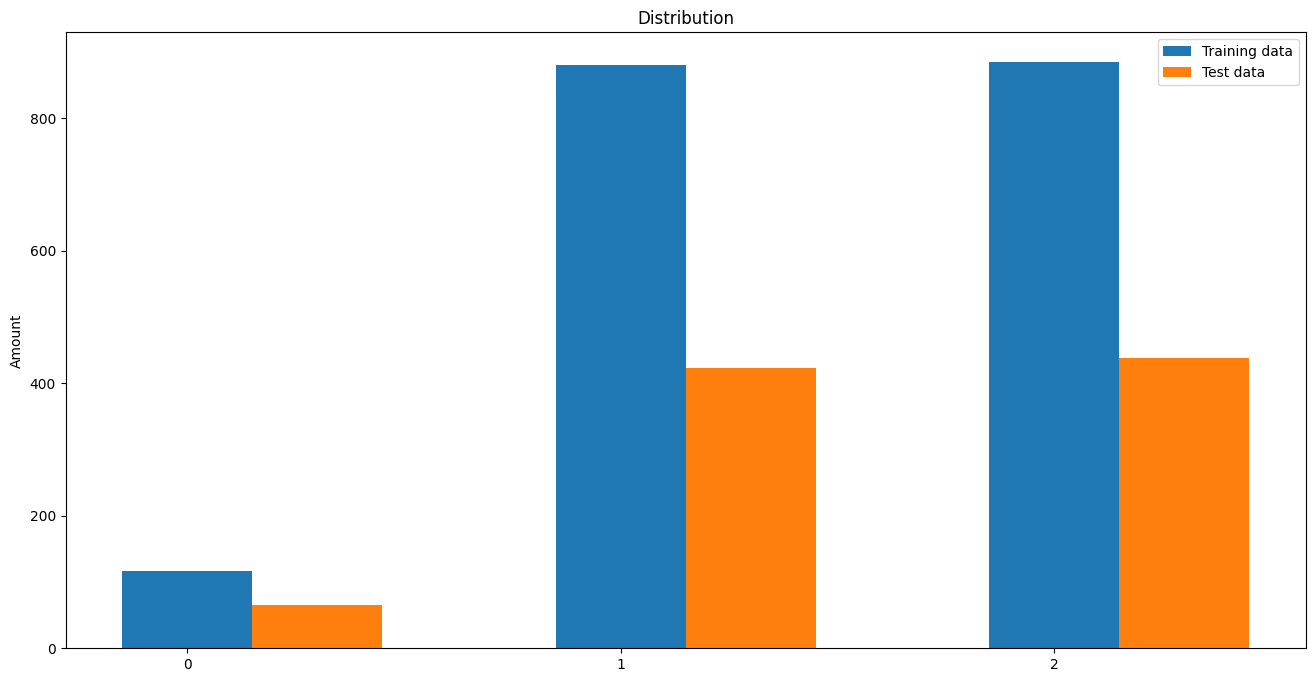


Example sequence from training set: [2 2 2 1 1] and its label: 1

Example sequence from training set: [2 2 0 2 1] and its label: 2


Random forest classifier accuracy: 45.52%
Random forest classifier accuracy: 46.82%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4543 - loss: 1.1099 - val_accuracy: 0.4542 - val_loss: 1.0339
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4551 - loss: 1.0073 - val_accuracy: 0.4725 - val_loss: 0.9627
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4705 - loss: 0.9526 - val_accuracy: 0.4595 - val_loss: 0.9398
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4859 - loss: 0.9226 - val_accuracy: 0.4563 - val_loss: 0.9306
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4734 - loss: 0.9188 - val_accuracy: 0.4498 - val_loss: 0.9194
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4680 - loss: 0.9044 - val_accuracy: 0.4682 - val_loss: 0.9134
Epoch 7/10
59/59 ━━━━━━

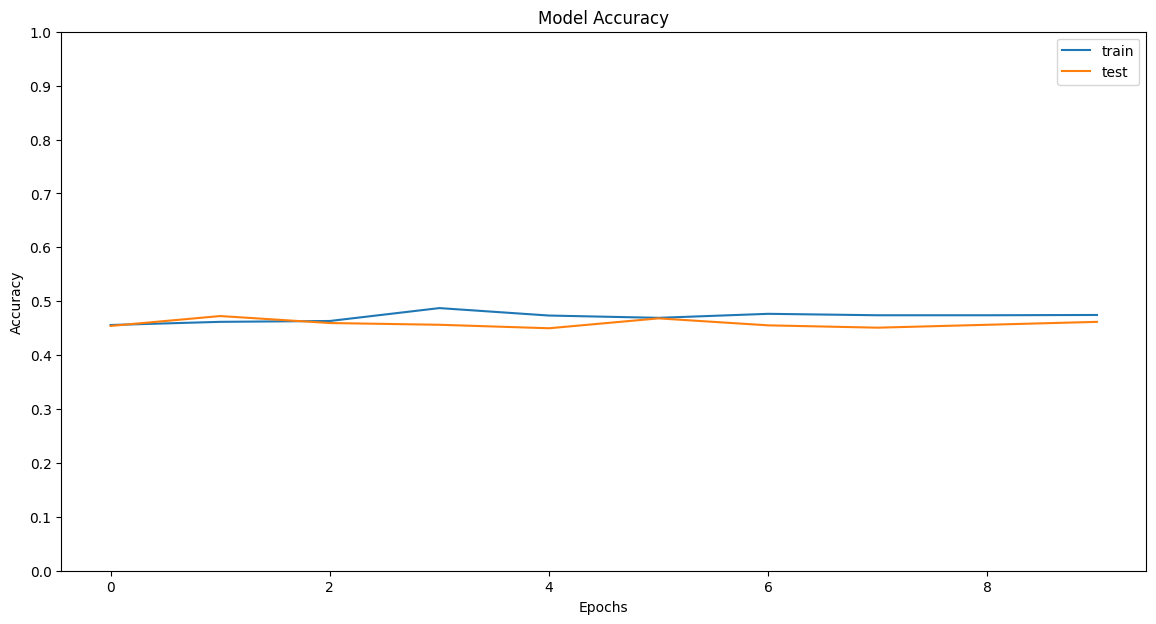

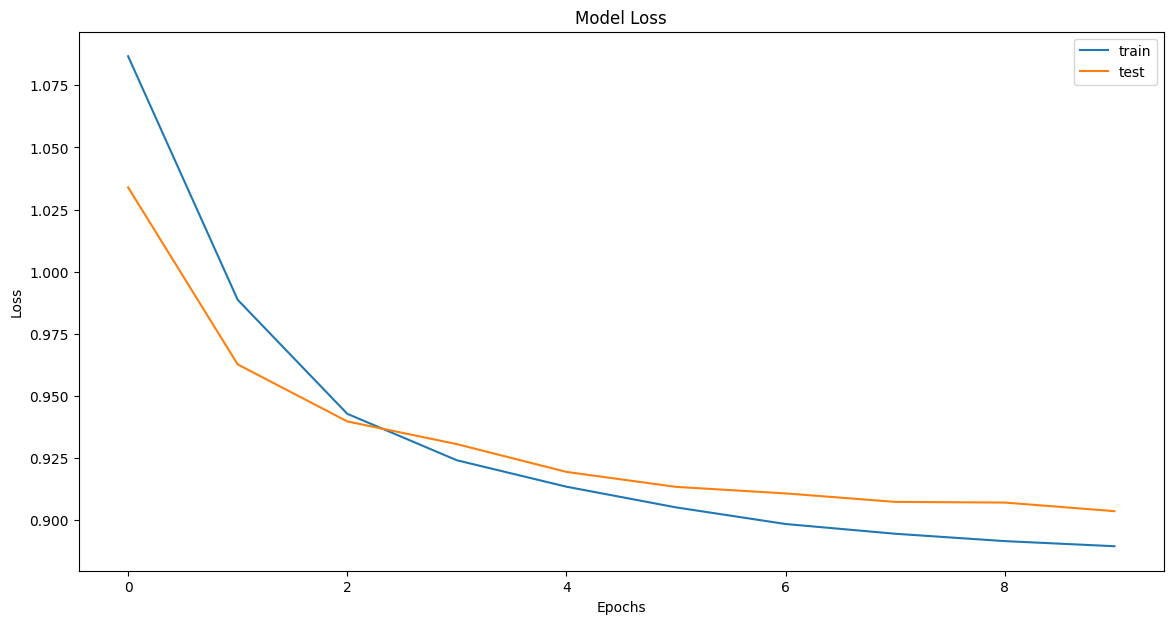

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Modal accuracy on test set: 46.17%


For threshold set to 0.40, correctness is: 46.17%
For threshold set to 0.45, correctness is: 46.17%
No data reaching 0.50 threshold
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 5, Epoch: 10, Accuracy: 0.46%

(10,)



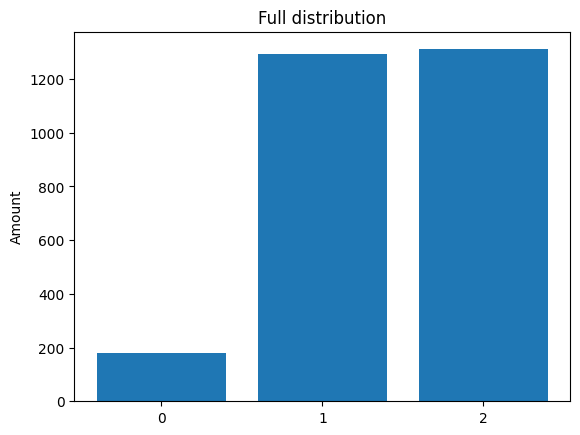

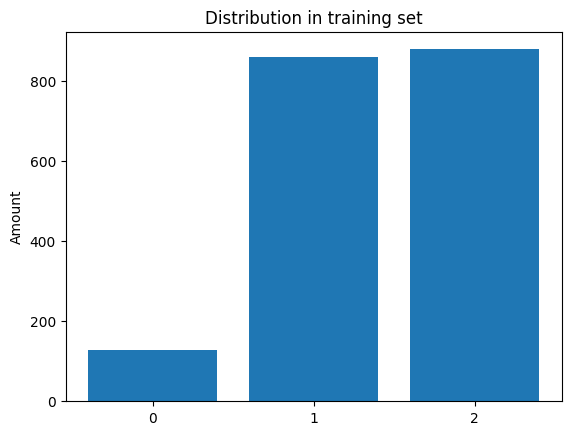

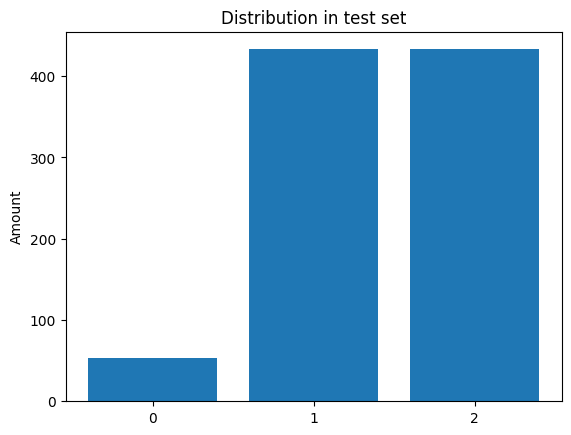

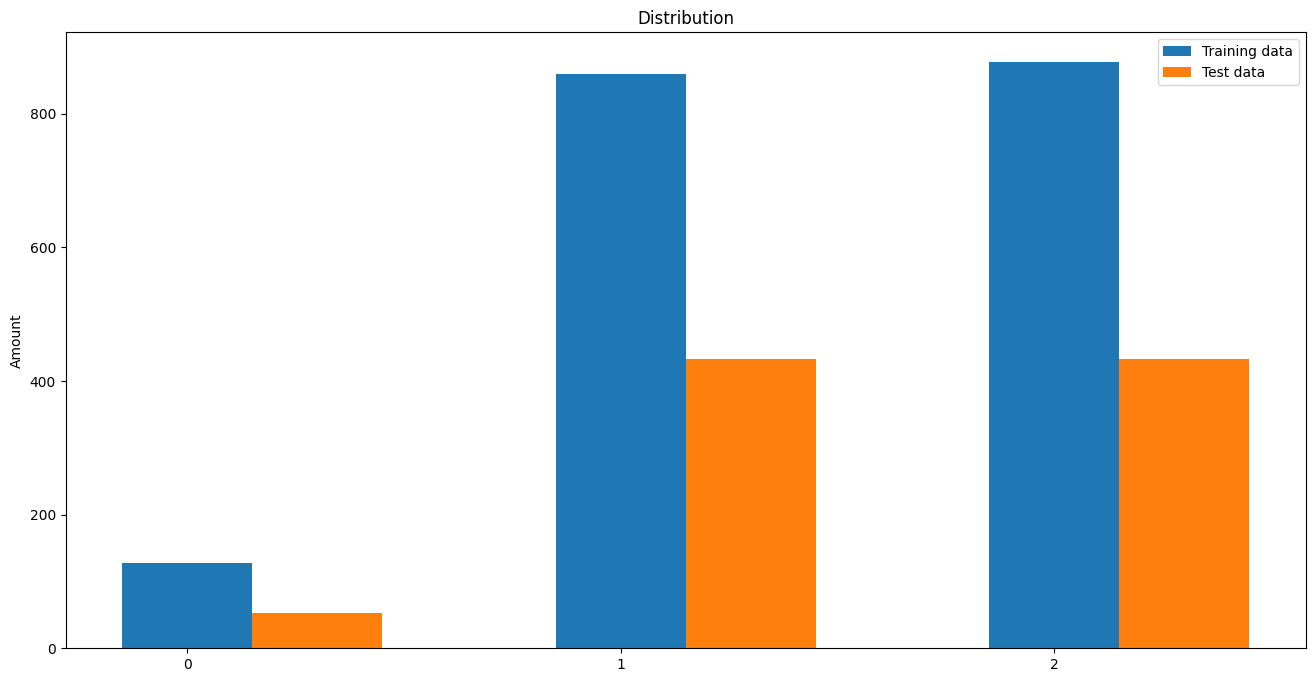


Example sequence from training set: [1 2 2 2 2 2 0 1 1 2] and its label: 2

Example sequence from training set: [1 1 2 2 1 2 1 0 1 1] and its label: 1


Random forest classifier accuracy: 46.35%
Random forest classifier accuracy: 42.98%


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4667 - loss: 1.0525 - val_accuracy: 0.4701 - val_loss: 0.9549
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4561 - loss: 0.9616 - val_accuracy: 0.4723 - val_loss: 0.9205
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4694 - loss: 0.9196 - val_accuracy: 0.4494 - val_loss: 0.9072
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4745 - loss: 0.9172 - val_accuracy: 0.4603 - val_loss: 0.8992
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4797 - loss: 0.9026 - val_accuracy: 0.4559 - val_loss: 0.8934
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4832 - loss: 0.9084 - val_accuracy: 0.4581 - val_loss: 0.8892
Epo

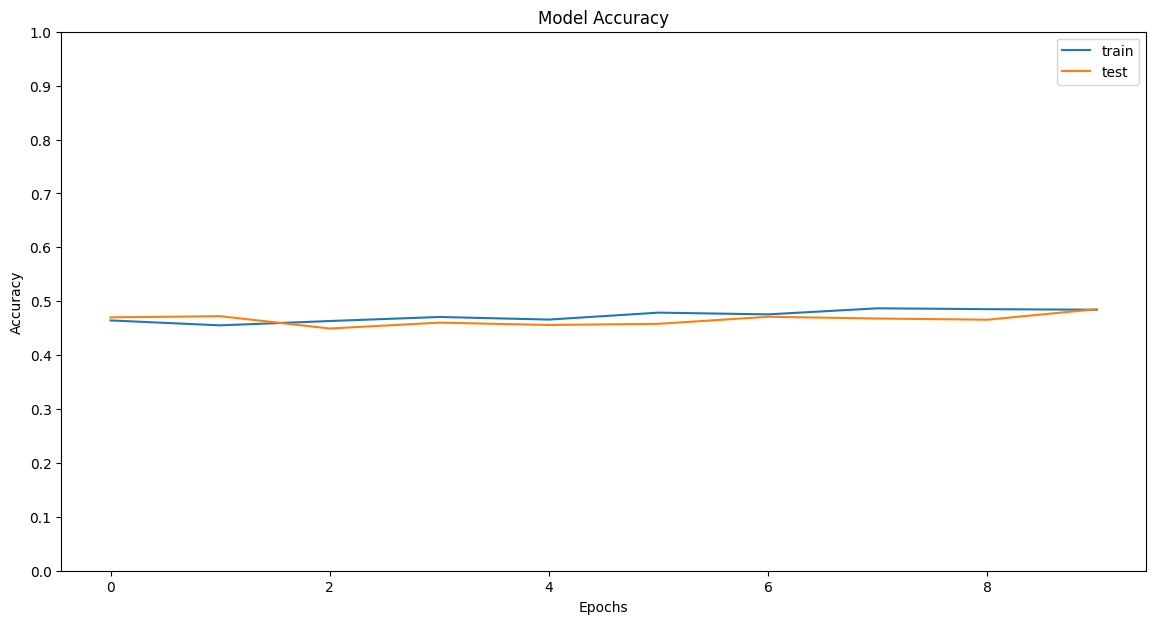

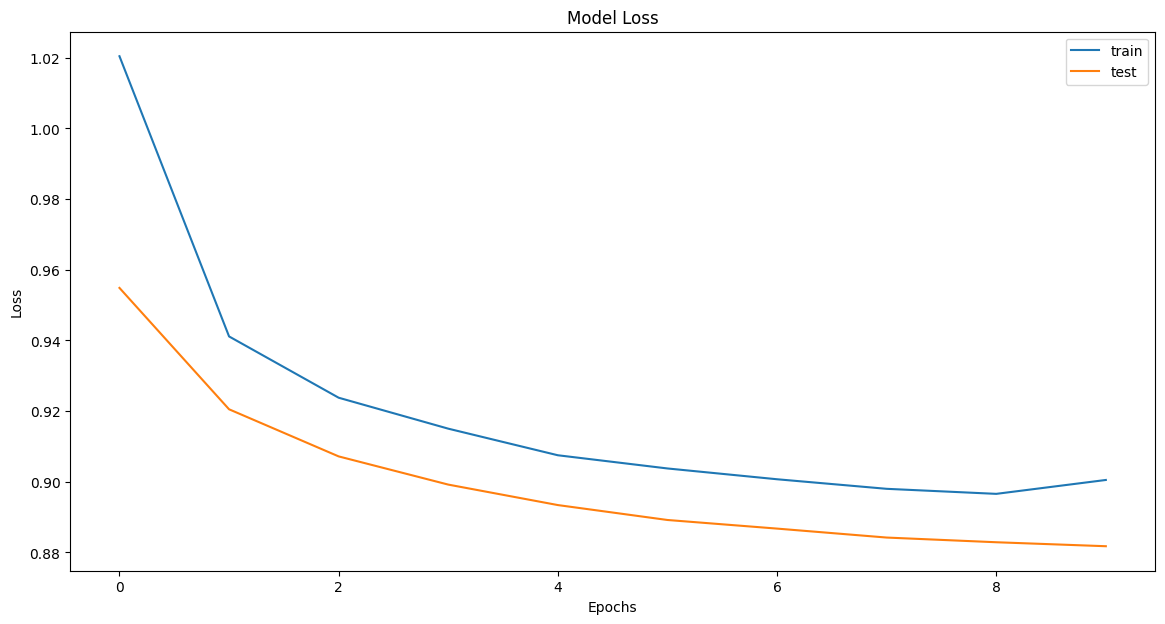

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Modal accuracy on test set: 48.53%


For threshold set to 0.40, correctness is: 48.53%
For threshold set to 0.45, correctness is: 48.53%
For threshold set to 0.50, correctness is: 66.67%
No data reaching 0.55 threshold
No data reaching 0.60 threshold
No data reaching 0.65 threshold
No data reaching 0.70 threshold
No data reaching 0.75 threshold
No data reaching 0.80 threshold
No data reaching 0.85 threshold


Top 3 results:
Chunk size: 10, Epoch: 10, Accuracy: 0.49%


In [10]:
CHUNK_SIZES_TO_TEST = [2,5,10]#,15,20,40]
EPOCHS_TO_TEST = [10]#,20,50]

for file in os.listdir("data"):
    print(f"\n====================\nData from file: {file}\n====================\n")
    colors = read_file(f"data/{file}")
    analize_dataset(colors, CHUNK_SIZES_TO_TEST, EPOCHS_TO_TEST)